# Plot multiple variables in the gridded $R_g$ vs $z_\mathrm{max}$ plane

In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [6]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>0.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 176753 stars in the parent sample


(-0.2, 0.6)

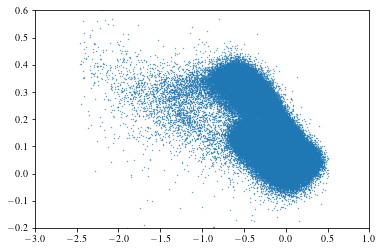

In [13]:
plt.scatter(data['FE_H'][mask],data['MG_FE'][mask],s=0.1)
plt.xlim(-3,1)
plt.ylim(-0.2,0.6)

In [43]:
feh_bins = np.around(np.linspace(-2.,0.6,14),decimals=2)
print(feh_bins)

[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6]


In [88]:
def plot_fe_afe_var_dens(fehs,afe,var1,var2, feh_n = 13, afe_n = 4,label1 = '$R_{g}$ [kpc]',label2='$z_{\mathrm{max}}$ [kpc]',\
                         xlim0=0,xlim1=15,ylim0=0,ylim1=5,nstarsx=1,nstarsy=4):
    
    """
    Function to plot two variables (var1,var2) gridded in an Rg-zmax plane
    
    INPUT: [Fe/H], [$\alpha$/Fe], variable 1, variable 2
    
    OUTPUT: Plot of var 1 vs var 2 in a grid of [Fe/H] and [$alpha$/Fe]
    
    """
    
    # split the Rg array into Rg_n bins (input 5)
    feh_bins = np.around(np.linspace(-2.,0.6,feh_n+1),decimals=2)
    afe_bins = np.flip(np.around(np.linspace(-0.2,0.6,afe_n+1),decimals=2))
    
    # create the plot
    fig, all_axes = plt.subplots(afe_n,feh_n, constrained_layout=True, figsize=(40, 12), sharex=True, sharey=True,rasterized=True)
    
    fig.suptitle('Metallicity, [Fe/H]', fontsize=50, y = 1.1)
    fig.supylabel(r'$\alpha$ over iron, [$\alpha$/Fe]',fontsize=50, x= -0.04)    

    # loop over the grid
    for indx, i in enumerate(afe_bins[:-1]):
        axis = all_axes[indx]
        for jndx, j in enumerate(feh_bins[:-1]):
            ax = axis[jndx]

            # create a mask for every loop
            mask_loop = (fehs>j)&(fehs<feh_bins[jndx+1])&(afe<i)&(afe>afe_bins[indx+1])
            # make the plot
            ax.hist2d(var1[mask_loop],var2[mask_loop],bins=50,norm=LogNorm(),cmap='binary')
#             ax.scatter(var1[mask_loop],var2[mask_loop],s=1,c='gray')

            ax.set_xlim(xlim0,xlim1)
            ax.set_ylim(ylim0,ylim1)
#             ax.plot([-0.6,-0.1],[0.35,0.2],color='r',lw=5)
            ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
            ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20)

    
    all_axes[0,0].set_title(r'' +str('%5.1f' %feh_bins[0])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[1]),fontsize=25,pad=15)
    all_axes[0,1].set_title(r'' +str('%5.1f' %feh_bins[1])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[2]),fontsize=25,pad=15)
    all_axes[0,2].set_title(r'' +str('%5.1f' %feh_bins[2])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[3]),fontsize=25,pad=15)
    all_axes[0,3].set_title(r'' +str('%5.1f' %feh_bins[3])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[4]),fontsize=25,pad=15)
    all_axes[0,4].set_title(r'' +str('%5.1f' %feh_bins[4])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[5]),fontsize=25,pad=15)
    all_axes[0,5].set_title(r'' +str('%5.1f' %feh_bins[5])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[6]),fontsize=25,pad=15)
    all_axes[0,6].set_title(r'' +str('%5.1f' %feh_bins[6])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[7]),fontsize=25,pad=15)
    all_axes[0,7].set_title(r'' +str('%5.1f' %feh_bins[7])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[8]),fontsize=25,pad=15)
    all_axes[0,8].set_title(r'' +str('%5.1f' %feh_bins[8])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[9]),fontsize=25,pad=15)
    all_axes[0,9].set_title(r'' +str('%5.1f' %feh_bins[9])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[10]),fontsize=25,pad=15)
    all_axes[0,10].set_title(r'' +str('%5.1f' %feh_bins[10])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[11]),fontsize=25,pad=15)
    all_axes[0,11].set_title(r'' +str('%5.1f' %feh_bins[11])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[12]),fontsize=25,pad=15)
    all_axes[0,12].set_title(r'' +str('%5.1f' %feh_bins[12])+ r'$<$ [Fe/H] $<$ '+str('%5.1f' %feh_bins[13]),fontsize=25,pad=15)
#     all_axes[0,13].set_title(r'' +str('%5.2f' %feh_bins[13])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[14]),fontsize=25,pad=15)
#     all_axes[0,14].set_title(r'' +str('%5.2f' %feh_bins[14])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[15]),fontsize=25,pad=15)

    all_axes[0,0].set_ylabel(r'' +str('%5.1f' %afe_bins[1])+ r'$<$ [$\alpha$/Fe] $<$ '+str('%5.1f' %afe_bins[0])+' \n '+str(label2),fontsize=25,labelpad=15)
    all_axes[1,0].set_ylabel(r'' +str('%5.1f' %afe_bins[2])+ r'$<$ [$\alpha$/Fe] $<$ '+str('%5.1f' %afe_bins[1])+' \n '+str(label2),fontsize=25,labelpad=15)
    all_axes[2,0].set_ylabel(r'' +str('%5.1f' %afe_bins[3])+ r'$<$ [$\alpha$/Fe] $<$ '+str('%5.1f' %afe_bins[2])+' \n '+str(label2),fontsize=25,labelpad=15)
    all_axes[3,0].set_ylabel(r'' +str('%5.1f' %afe_bins[3])+ r'$<$ [$\alpha$/Fe] $<$ '+str('%5.1f' %afe_bins[2])+' \n '+str(label2),fontsize=25,labelpad=15)
    
#     all_axes[0,0].text(-0.5,1.35,'Metal-poor', fontsize=40)
#     all_axes[0,-1].text(-0.5,1.35,'Metal-rich', fontsize=40)

#     fig.arrow(0.5,0.35,dx=5,dy=1,color='k',head_width=0.2,head_length=0.2)
#     cbar = fig.colorbar(color, ax = axis, aspect=15)
#     cbar.set_label(label='N$_{\mathrm{stars}}$',fontsize=25)
#     cbar.ax.tick_params(labelsize=25)
    
    for ax in all_axes[-1]:
        ax.set_xlabel(label1,fontsize=25,labelpad=4)
#     for ax in all_axes[:, 0]:
#         ax.set_ylabel(label2,fontsize=30)

#     fig.savefig('../plots/rg-zmax-mgfe.pdf',dpi=150)


In [17]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])


# $R_g-z_{\mathrm{max}}$

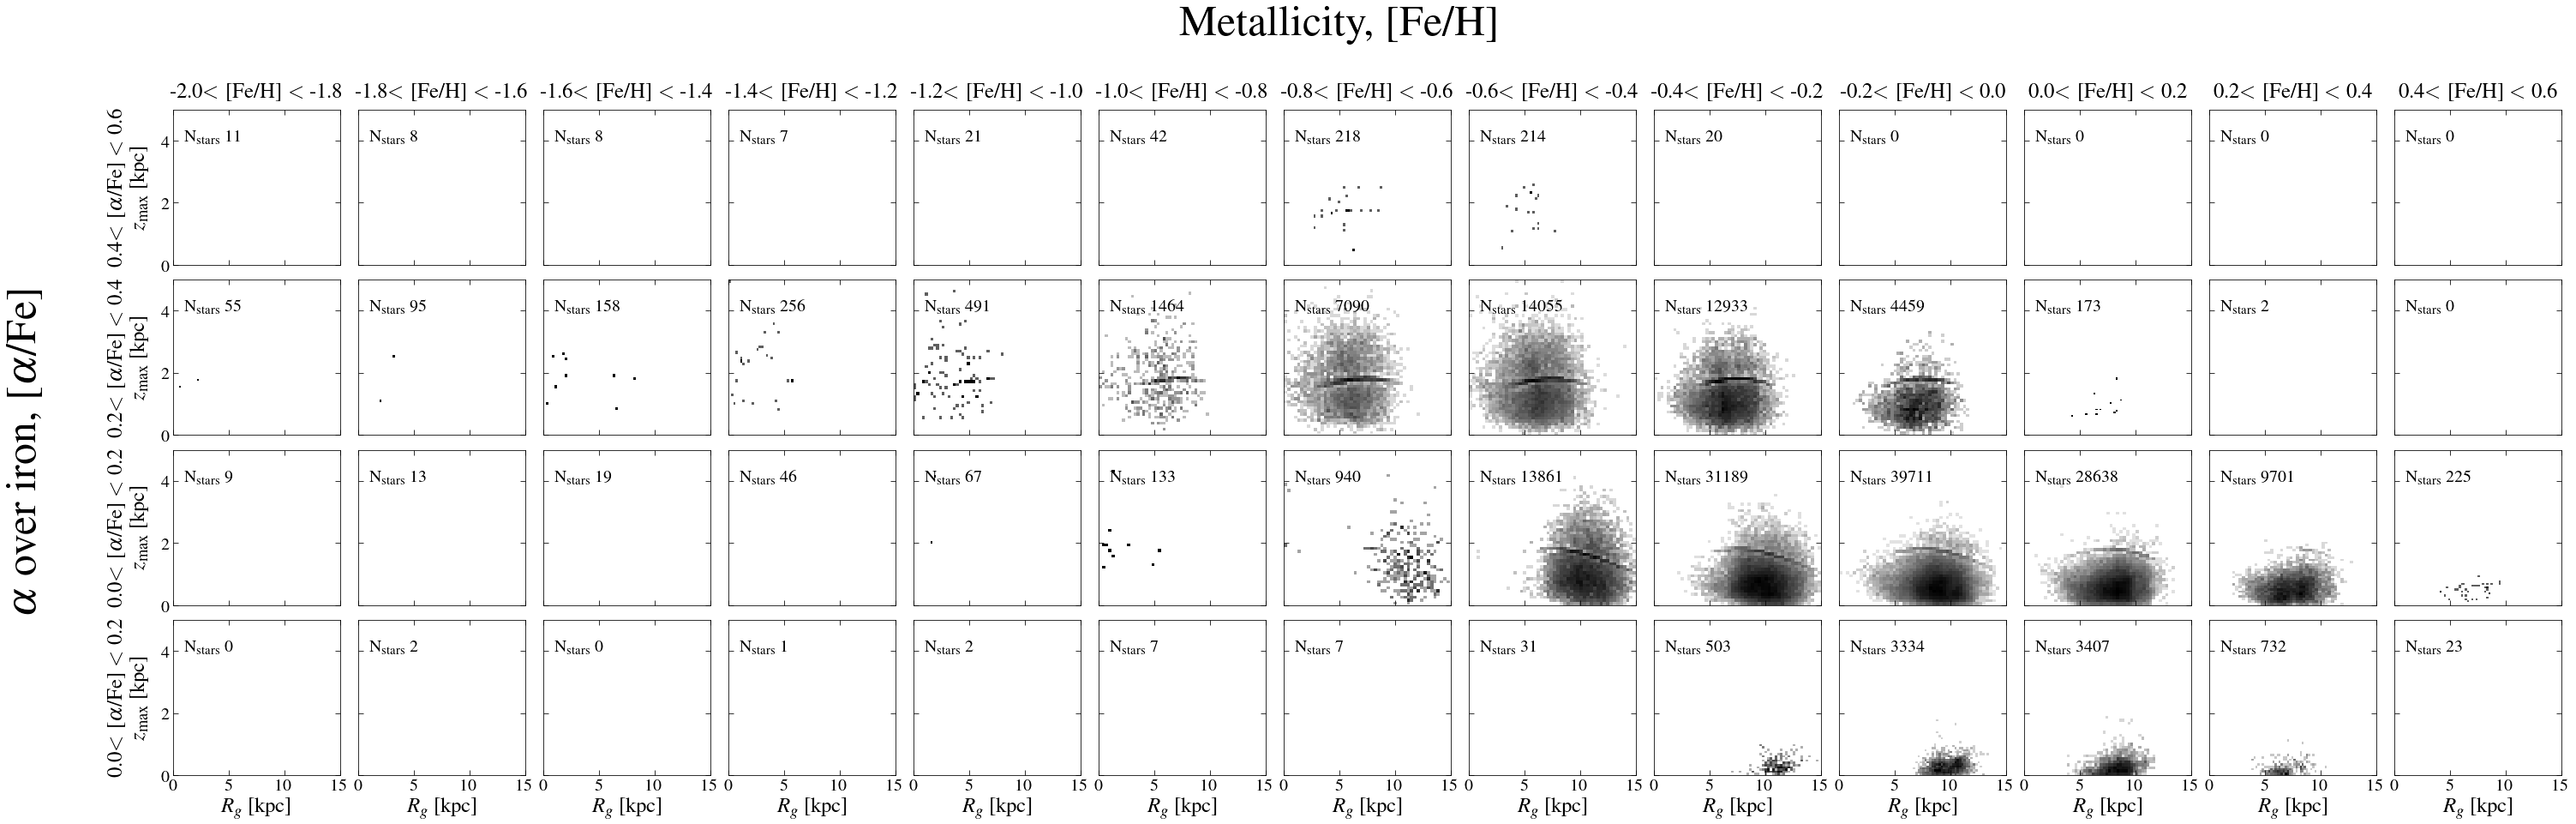

In [89]:
mgh = data['MG_FE']+data['FE_H']
femg = data['FE_H']-mgh

mask_plot = (Rg>0)&(Rg<15)&(data['z_max']>0)&(data['z_max']<5)&(np.abs(femg)<3)&(np.abs(mgh)<3)&mask


plot_fe_afe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],Rg[mask_plot],data['z_max'][mask_plot])

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Rg-zmax-tinsley-dens.pdf',dpi=200, bbox_inches = 'tight')


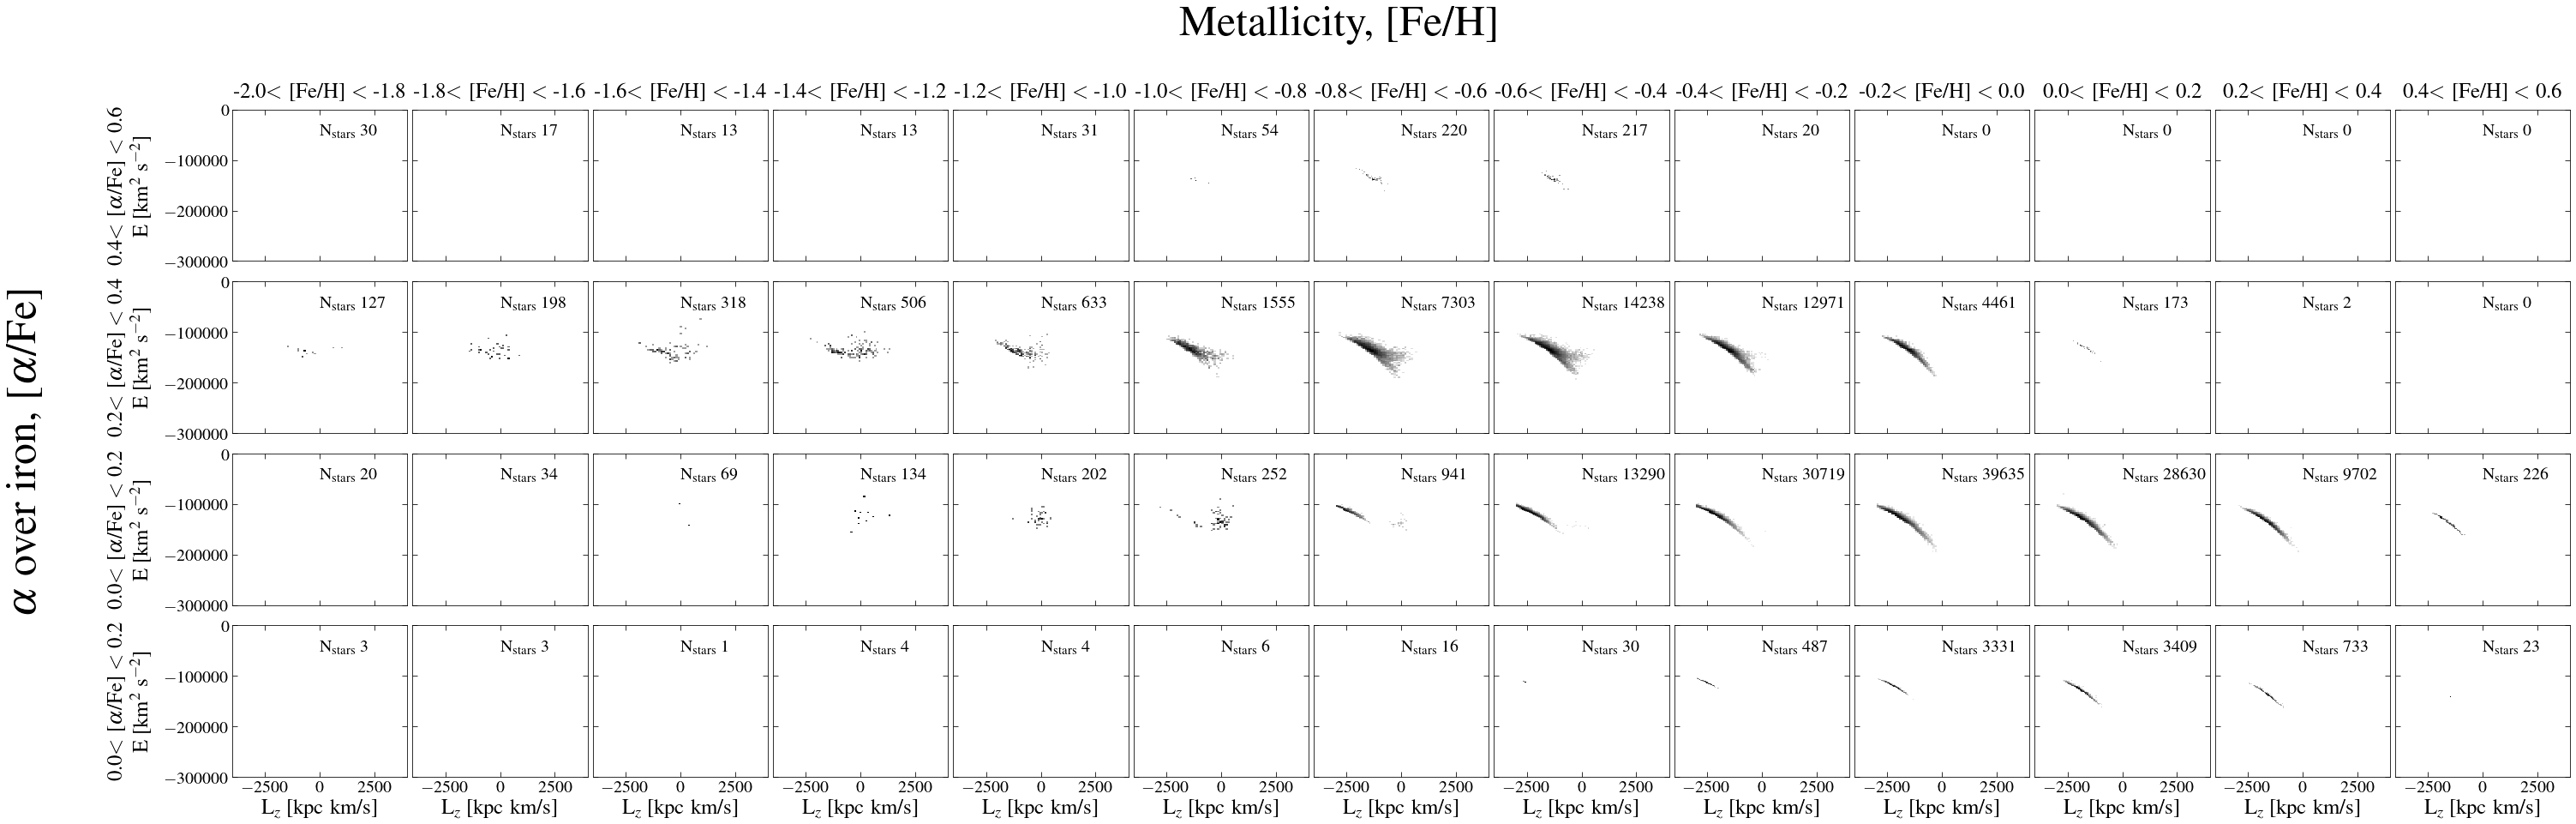

In [90]:
mask_plot = (data['L'][:,2]>-3e3)&(data['L'][:,2]<3e3)&(data['E']<0)&(data['E']>-3e5)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask

plot_fe_afe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['L'][:,2][mask_plot],data['E'][mask_plot]\
                    ,xlim0=-4e3,xlim1=4e3,ylim0=-3e5, ylim1=0,nstarsx=0,nstarsy=-5e4, label1=r'L$_{z}$ [kpc km/s]',\
                    label2 = r'E [km$^{2}$ s$^{-2}$]') 
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/E-Lz-tinsley-dens.pdf',dpi=200, bbox_inches = 'tight')


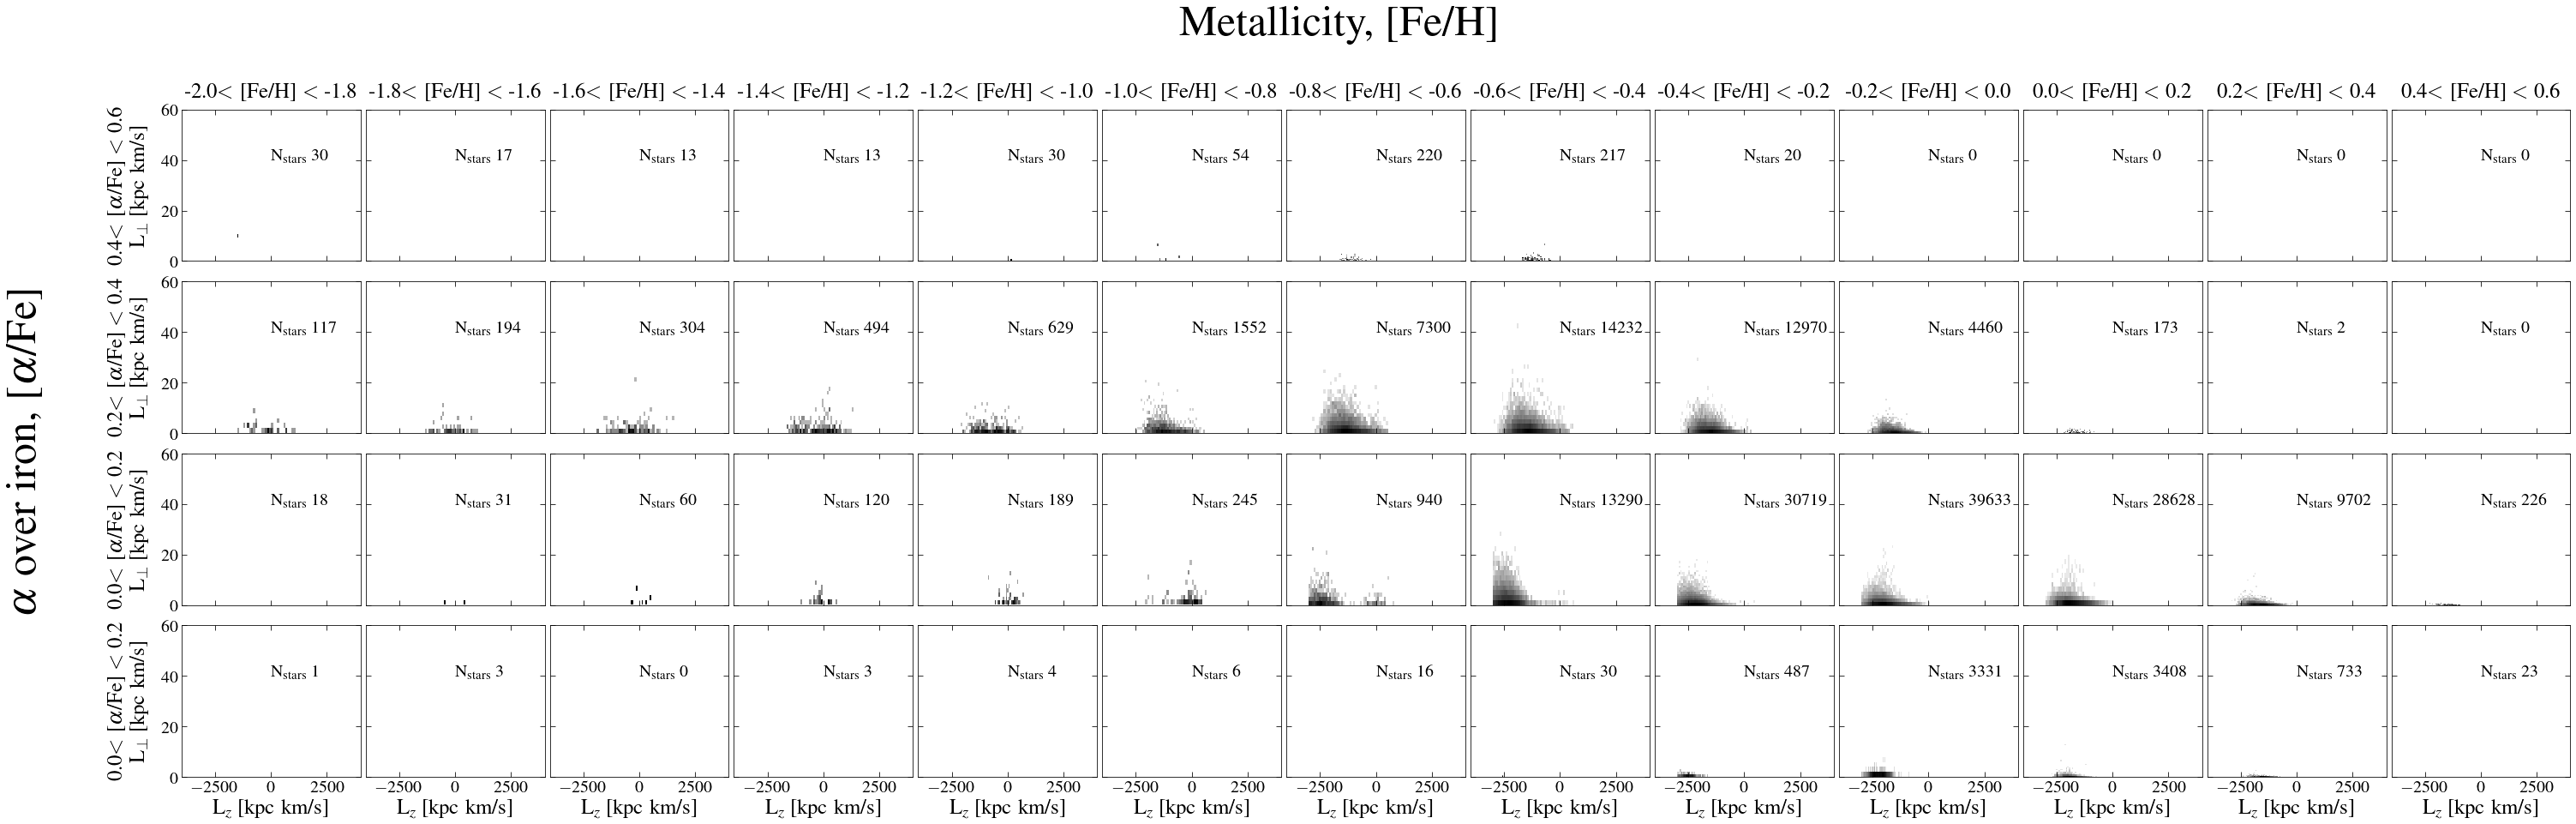

In [91]:
Lperp = np.sqrt(data['L'][:,0]**2+data['L'][:,1]**2)

mask_plot = (data['L'][:,2]>-3e3)&(data['L'][:,2]<3e3)&(Lperp>0)&(Lperp<100)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask

plot_fe_afe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['L'][:,2][mask_plot],Lperp[mask_plot]\
                    ,xlim0=-4e3,xlim1=4e3,ylim0=0, ylim1=60,nstarsx=0,nstarsy=40, label1=r'L$_{z}$ [kpc km/s]',\
                    label2 = r'L$_{\perp}$ [kpc km/s]') 
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Lperp-Lz-tinsley-dens.pdf',dpi=200, bbox_inches = 'tight')



# Split into high-/low-$\alpha$ and halo and then plot the $R_g$ vs $z_{\mathrm{max}}$ in bins of delta R

In [112]:
line = data['FE_H']*-0.167 + 0.12

lowa_disc_mask = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))


higha_disc_mask_strict = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))

higha_disc_mask = ((data['FE_H']>-1)&(data['FE_H']<0.)&(data['MG_FE']>line))|((data['FE_H']>0.)&(data['FE_H']<0.6)&(data['MG_FE']>0.12))


inta_disc_mask = ((data['FE_H']>-0.4)&(data['FE_H']<-0.0)&(data['MG_FE']>line)&(data['MG_FE']<0.22))|((data['FE_H']>0.0)&(data['FE_H']<0.6)&(data['MG_FE']>0.12)&(data['MG_FE']<0.22))

other_mask = (~higha_disc_mask)&(~lowa_disc_mask)&(data['FE_H']<-0.6)

print(len(data[mask&lowa_disc_mask]))
print(len(data[mask&higha_disc_mask]))
print(len(data[mask&other_mask]))


123226
49914
3173


In [349]:
def plot_3_3(var1, var2, var3, abun, mask1, mask2, mask3,n=5,nbins=91,xfe_label=r'$\langle$[Mg/Fe]$\rangle$',\
            label1=r'$\Delta R$ [kpc]', label2 = r'$R_{g}$ [kpc]', label3=r'$z_{\mathrm{max}}$ [kpc]',\
            xlim1 = 0, xlim2 = 15, ylim1 =0, ylim2 = 8,xnstar = 9, ynstar = 7):
    """
    Take three variables (say J) and 3 samples (say high-/low-alpha discs and halo) and plot two variables conditioned
    on the other. 
    """
    
    fig, all_axes = plt.subplots(3, 4, constrained_layout=True, figsize=(30, 18), sharex=True, sharey=True, rasterized=True)
    
    # for mask1
    xs = np.around(np.linspace(np.min(var1[mask1]),np.max(var1[mask1]),n),decimals=2)
    # for mask2
    xs2 = np.around(np.linspace(np.min(var1[mask2]),np.max(var1[mask2]),n),decimals=2)
    # for mask3
    xs3 = np.around(np.linspace(np.min(var1[mask3]),np.max(var1[mask3]),n),decimals=2)   
    
    # set up an array of the x grids to loop over
    exis = np.array((xs,xs2,xs3))
    
    for indx, i in enumerate(exis):
        axis = all_axes[indx]
        for indx2, k in enumerate(i[:-1]):
                # create a mask for every loop
                if k<i[-1] and indx==0:
                        mask_loop = (var1[mask1]>k)&(var1[mask1]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask1]),np.max(var2[mask1]),nbins)
                        biny = np.linspace(np.min(var3[mask1]),np.max(var3[mask1]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask1][mask_loop],var3[mask1][mask_loop], abun[mask1][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.05,vmax=0.12)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask1][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                        
                if k<i[-1] and indx==1:
                        mask_loop = (var1[mask2]>k)&(var1[mask2]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask2]),np.max(var2[mask2]),nbins)
                        biny = np.linspace(np.min(var3[mask2]),np.max(var3[mask2]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask2][mask_loop],var3[mask2][mask_loop], abun[mask2][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=0.15,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask2][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()

                if k<i[-1] and indx==2:
                        mask_loop = (var1[mask3]>k)&(var1[mask3]<i[indx2+1])
                        ax = axis[indx2]
                        binx = np.linspace(np.min(var2[mask3]),np.max(var2[mask3]),nbins)
                        biny = np.linspace(np.min(var3[mask3]),np.max(var3[mask3]),nbins)
                        hist = stats.binned_statistic_2d(var2[mask3][mask_loop],var3[mask3][mask_loop], abun[mask3][mask_loop], statistic='mean', bins=[binx,biny])
                        plot_x, plot_y = np.meshgrid(binx,biny) 
                        color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-0.1,vmax=0.3)         
                        ax.set_xlim(xlim1,xlim2)
                        ax.set_ylim(ylim1,ylim2)
                        ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                        ax.text(xnstar,ynstar,r'N$_{\mathrm{stars}}$ '+str(len(var1[mask3][mask_loop])),fontsize=25)
                        ax.set_title(r'' +str('%5.2f' %k)+ r'$<$ '+str(label1)+' $<$ '+str('%5.2f' %i[indx2+1]),fontsize=30)
                        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=12)
                        ax.tick_params(which='minor', length=6, direction='in',top=True,right=True)
                        ax.minorticks_on()
                else:
                    pass
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        cbar.set_label(label=xfe_label,fontsize=25)
        cbar.ax.tick_params(labelsize=25)

    for ax in all_axes[-1]:
        ax.set_xlabel(label2,fontsize=40)

    all_axes[0,0].set_ylabel(r'Low-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[1,0].set_ylabel(r'High-$\alpha$ disc' +' \n '+str(label3),fontsize=40,labelpad=15)
    all_axes[2,0].set_ylabel(r'Halo' +' \n '+str(label3),fontsize=40,labelpad=15)
  


    
    
    

In [351]:
deltaR = Rgal-Rg
lowa =mask&lowa_disc_mask&(deltaR>-3)&(deltaR<3)&(Rg>0)&(Rg<15)&(data['z_max']>0)&(data['z_max']<10)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(data['z_max']))
higha = mask&higha_disc_mask&(deltaR>-3)&(deltaR<3)&(Rg>0)&(Rg<15)&(data['z_max']>0)&(data['z_max']<10)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(data['z_max']))
halo = mask&other_mask&(deltaR>-3)&(deltaR<10)&(Rg>0)&(Rg<15)&(data['z_max']>0)&(data['z_max']<10)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(data['z_max']))


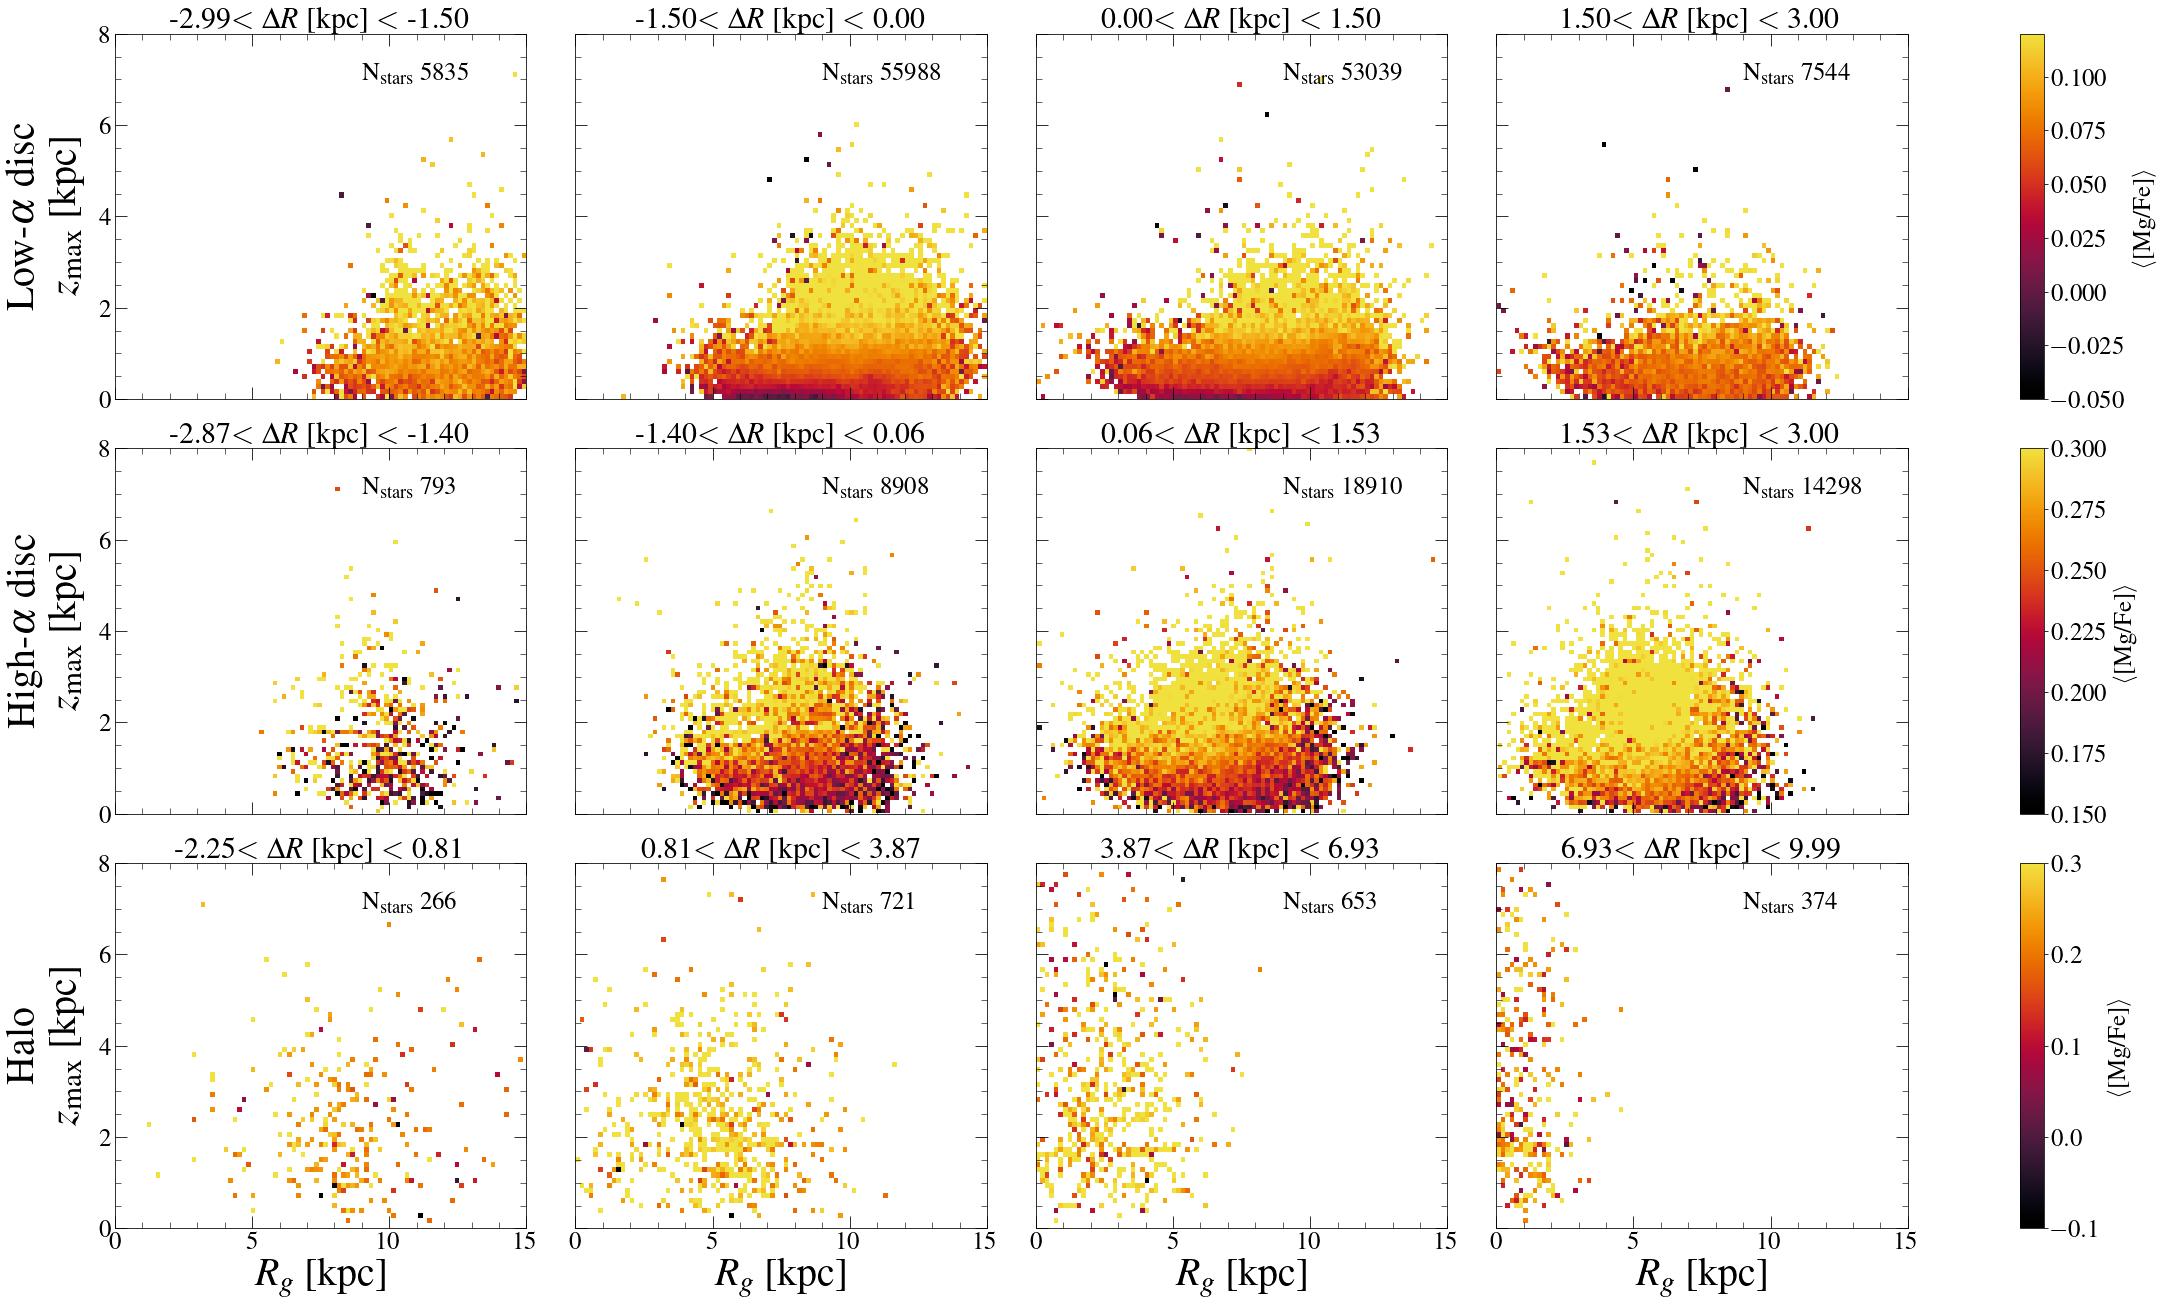

In [352]:
plot_3_3(deltaR,Rg,data['z_max'],data['MG_FE'],lowa,higha,halo)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Rg-zmax-deltaR-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Make the same plots with the actions

In [329]:
jr = data['actions'][:,0]
jphi = data['actions'][:,1]*-1
jz = data['actions'][:,2]

lowa =mask&lowa_disc_mask&(jr>0)&(jr<100)&(jphi>-5e4)&(jphi<5e4)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
higha = mask&higha_disc_mask&(jr>0)&(jr<200)&(jphi>-5e4)&(jphi<5e4)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
halo = mask&other_mask&(jr>0)&(jr<800)&(jphi>-5e4)&(jphi<5e4)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))

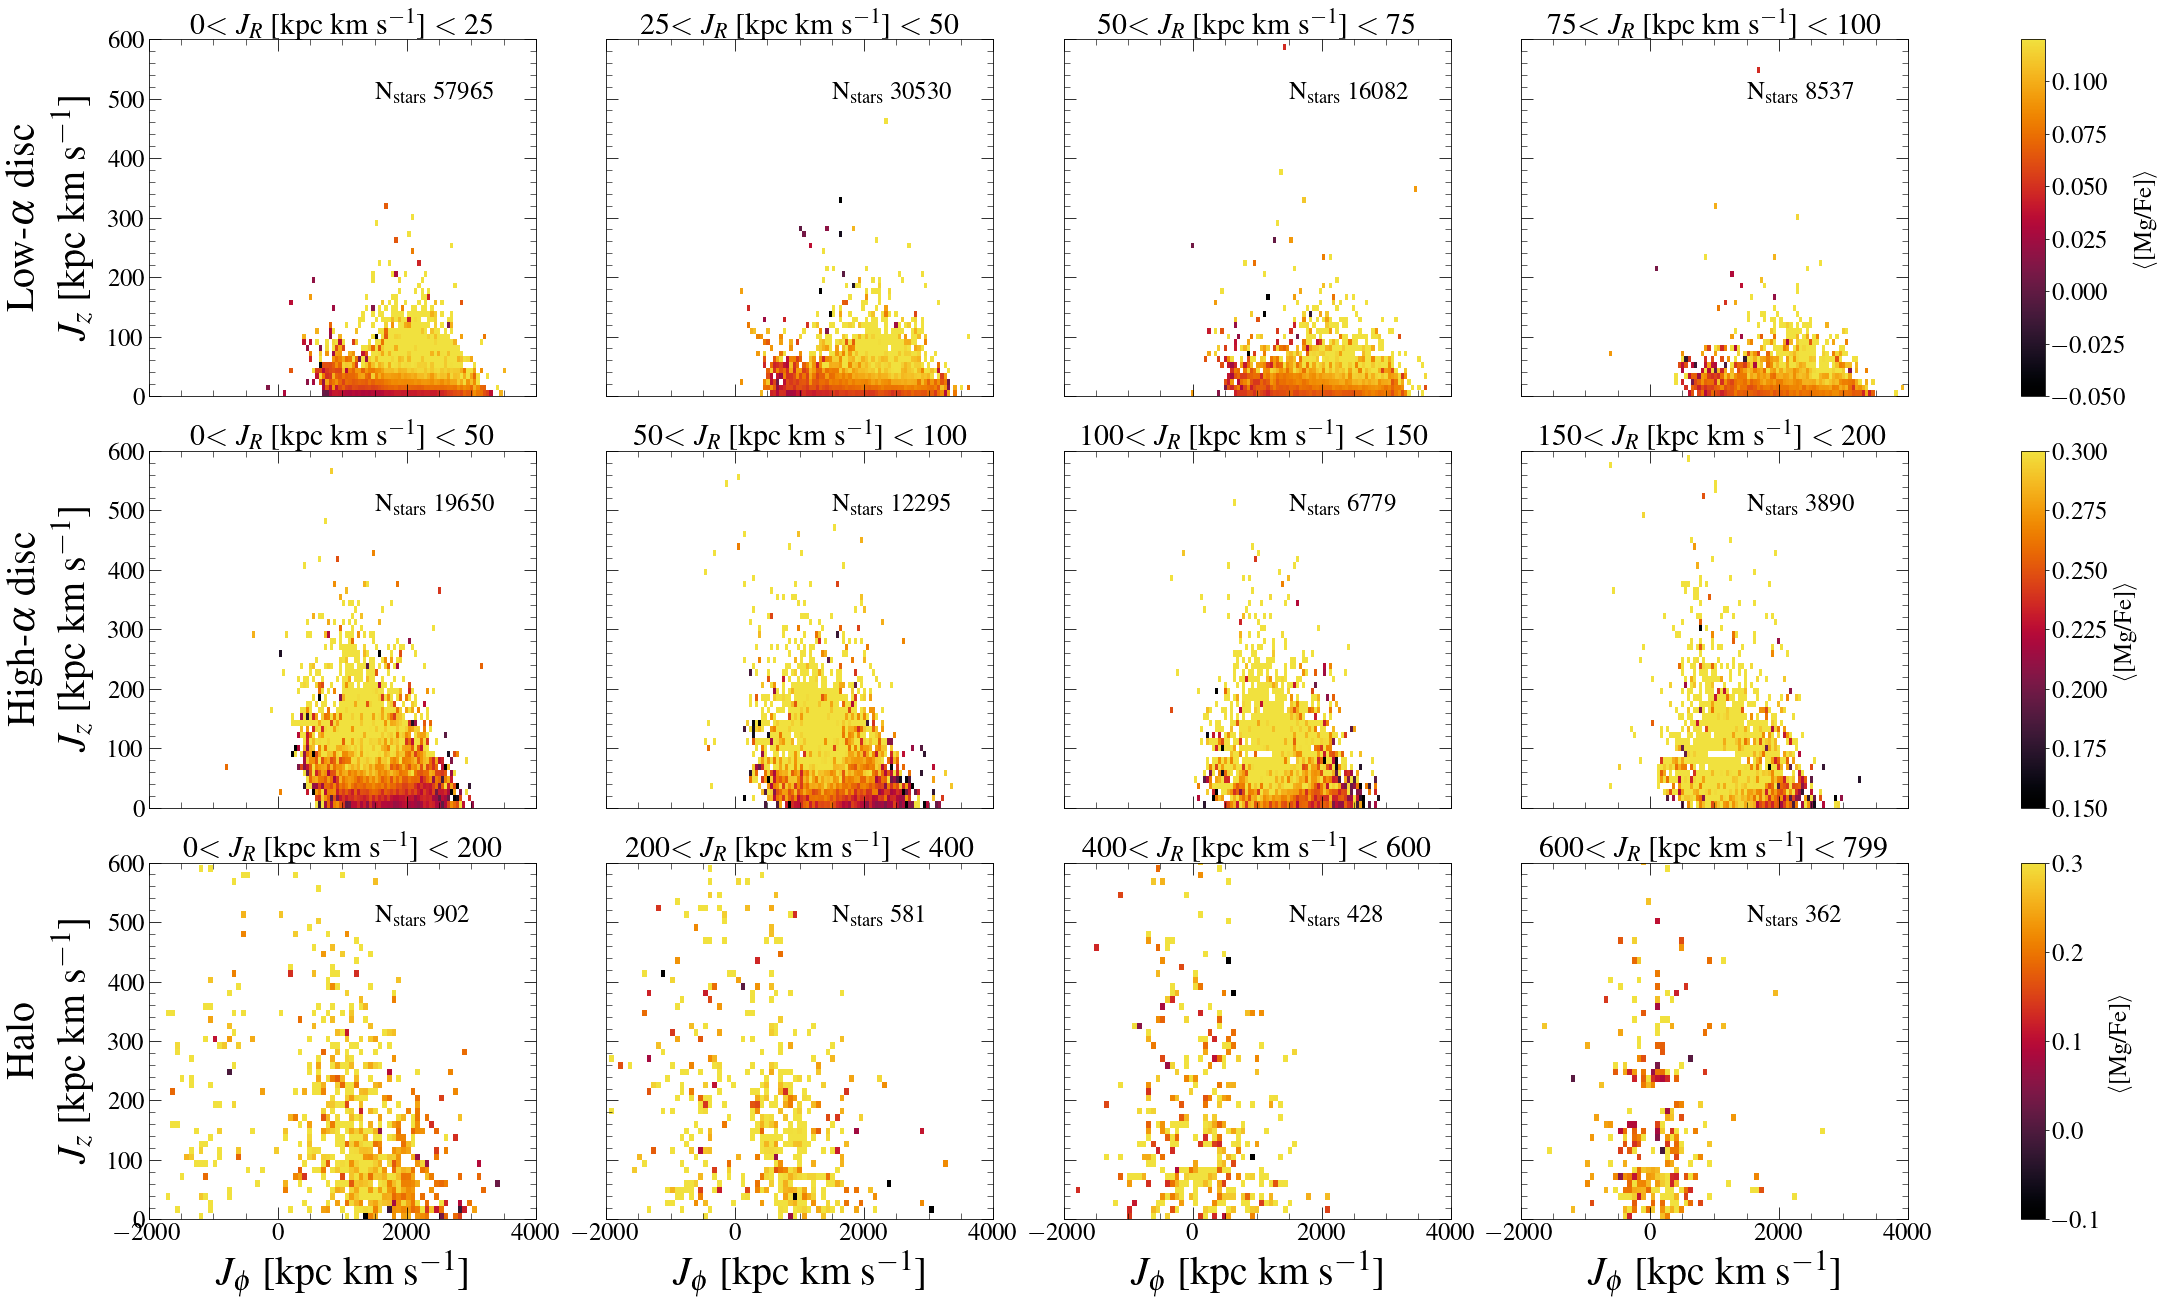

In [330]:
plot_3_3(jr,jphi,jz,data['MG_FE'],lowa,higha,halo,label1=r'$J_{R}$ [kpc km s$^{-1}$]',\
         label2 = r'$J_{\phi}$ [kpc km s$^{-1}$]', label3=r'$J_{z}$ [kpc km s$^{-1}$]',\
            xlim1 = -2e3, xlim2 = 4e3, ylim1 =0, ylim2 = 600,xnstar = 1.5e3, ynstar = 500)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/actions-Jr-3x3.pdf',dpi=200, bbox_inches = 'tight')


(array([1.0000e+01, 2.0000e+01, 1.4700e+02, 9.1300e+02, 3.5860e+03,
        2.5903e+04, 9.6151e+04, 4.7744e+04, 1.9550e+03, 2.0000e+01]),
 array([-3245.86566817, -2470.83465381, -1695.80363946,  -920.77262511,
         -145.74161076,   629.28940359,  1404.32041794,  2179.3514323 ,
         2954.38244665,  3729.413461  ,  4504.44447535]),
 <BarContainer object of 10 artists>)

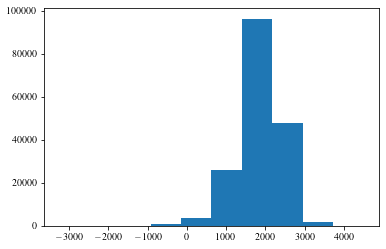

In [320]:
plt.hist(jphi[mask&(jphi>-5e4)&(jphi<5e4)])

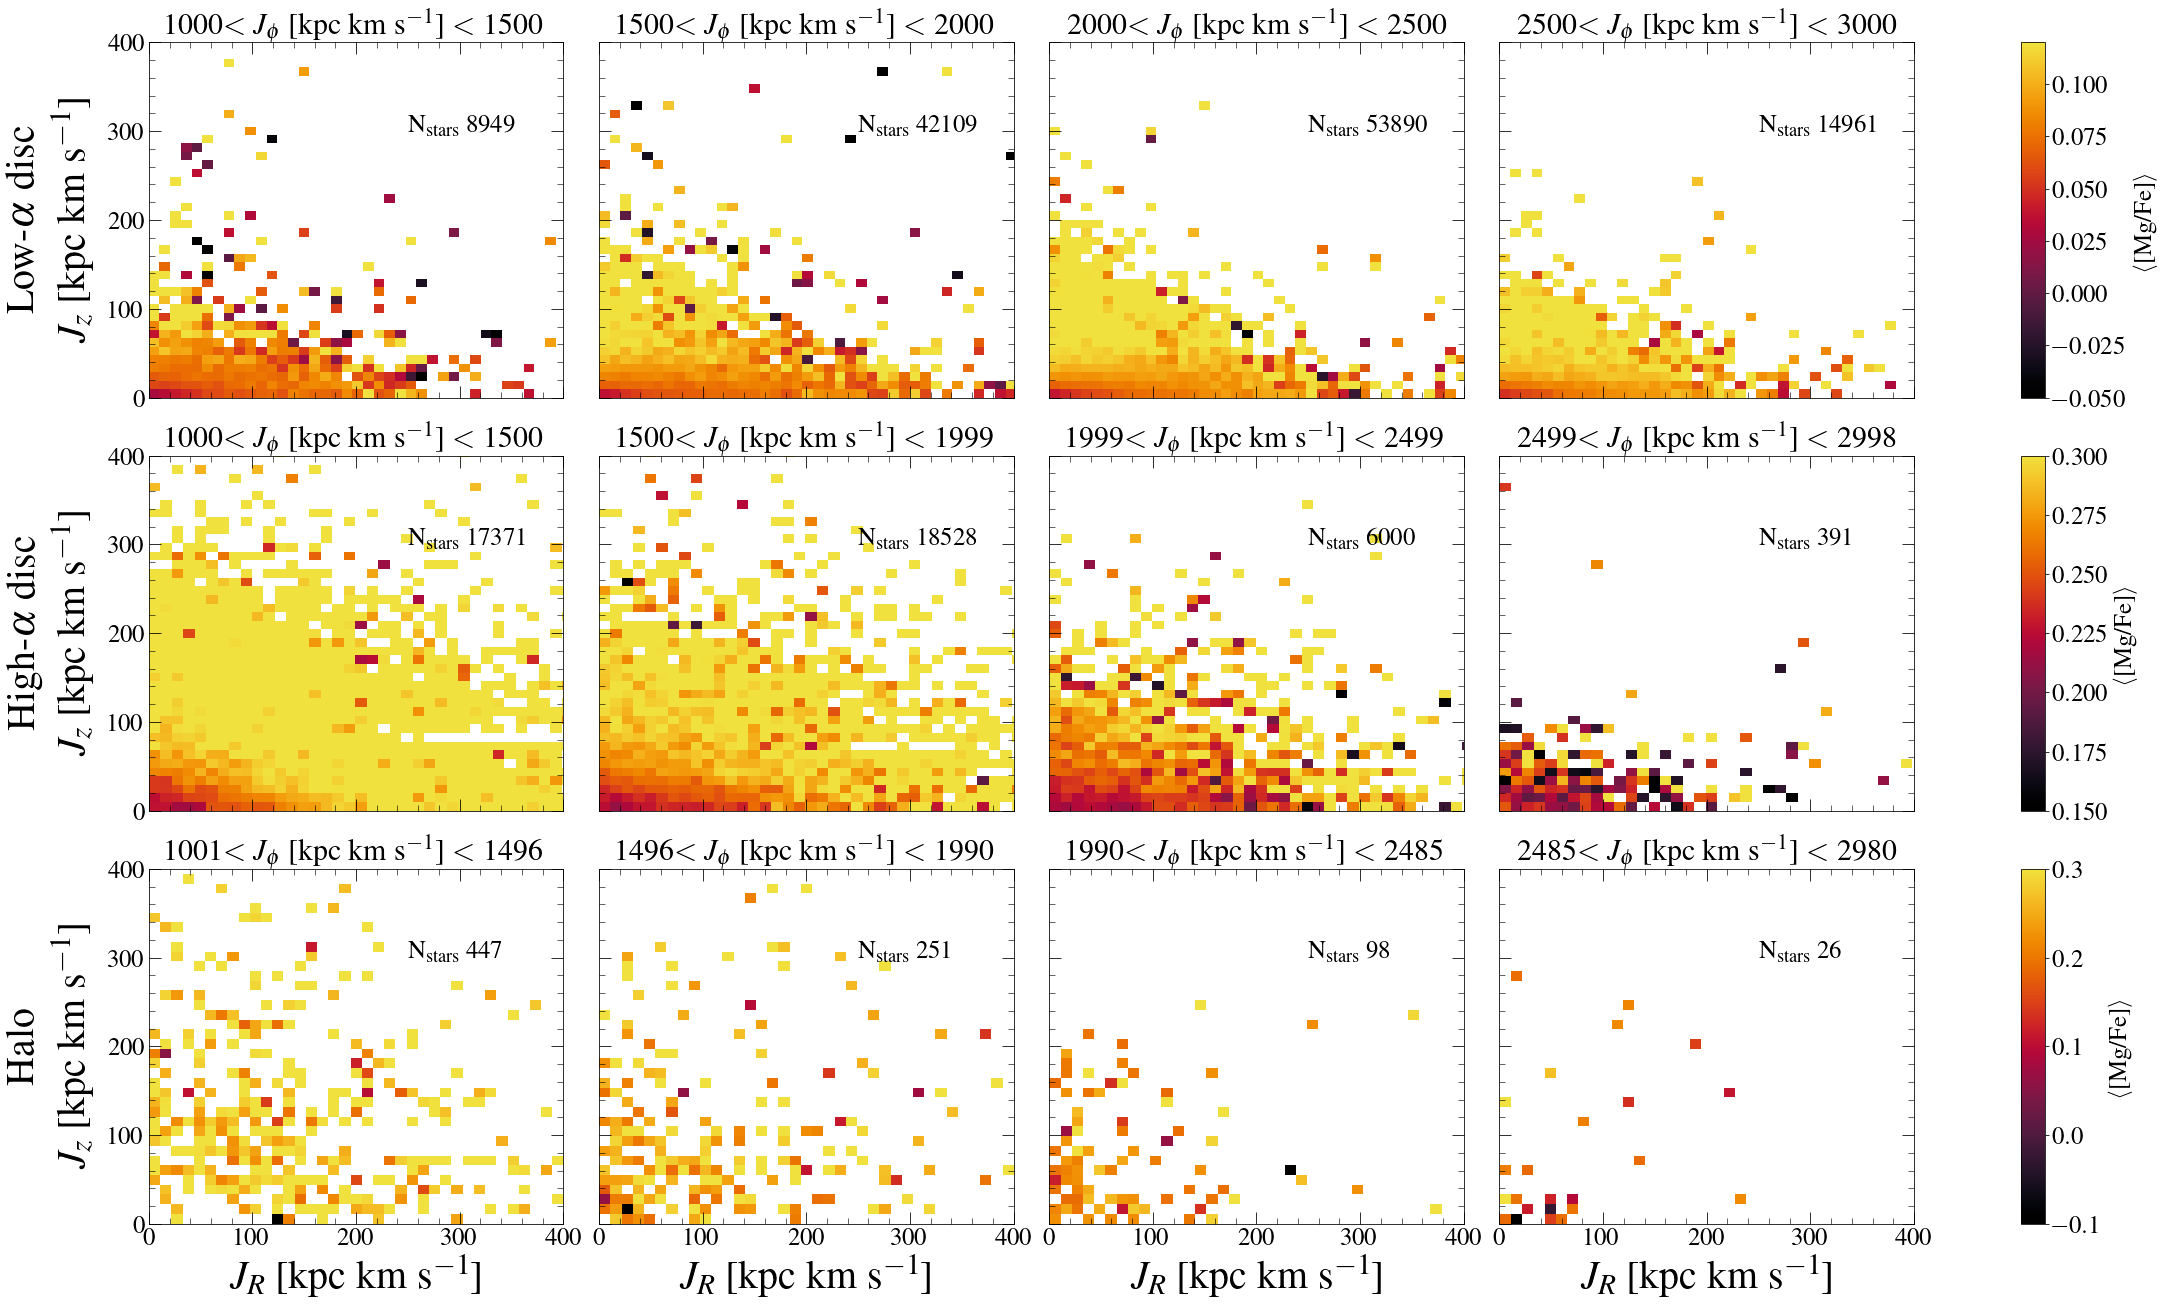

In [328]:
lowa =mask&lowa_disc_mask&(jr>0)&(jr<1e3)&(jphi>1e3)&(jphi<3e3)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
higha = mask&higha_disc_mask&(jr>0)&(jr<1e3)&(jphi>1e3)&(jphi<3e3)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
halo = mask&other_mask&(jr>0)&(jr<1e3)&(jphi>1e3)&(jphi<3e3)&(jz>0)&(jz<1e3)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))

plot_3_3(jphi,jr,jz,data['MG_FE'],lowa,higha,halo,label1=r'$J_{\phi}$ [kpc km s$^{-1}$]',\
         label2 = r'$J_{R}$ [kpc km s$^{-1}$]', label3=r'$J_{z}$ [kpc km s$^{-1}$]',\
            xlim1 = 0, xlim2 = 400, ylim1 =0, ylim2 = 400,xnstar = 250, ynstar = 300)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/actions-Jphi-3x3.pdf',dpi=200, bbox_inches = 'tight')


(array([3.00000e+00, 8.00000e+00, 1.10000e+01, 2.20000e+01, 1.82500e+04,
        1.55488e+05, 2.06900e+03, 3.24000e+02, 1.18000e+02, 4.30000e+01]),
 array([-995.52374855, -796.03092228, -596.53809602, -397.04526975,
        -197.55244349,    1.94038278,  201.43320905,  400.92603531,
         600.41886158,  799.91168784,  999.40451411]),
 <BarContainer object of 10 artists>)

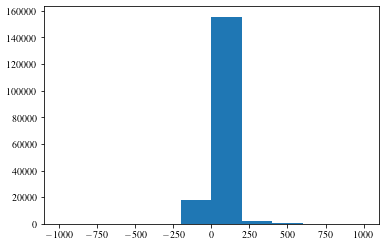

In [332]:
plt.hist(jz[mask&(jz>-1e3)&(jz<1e3)])

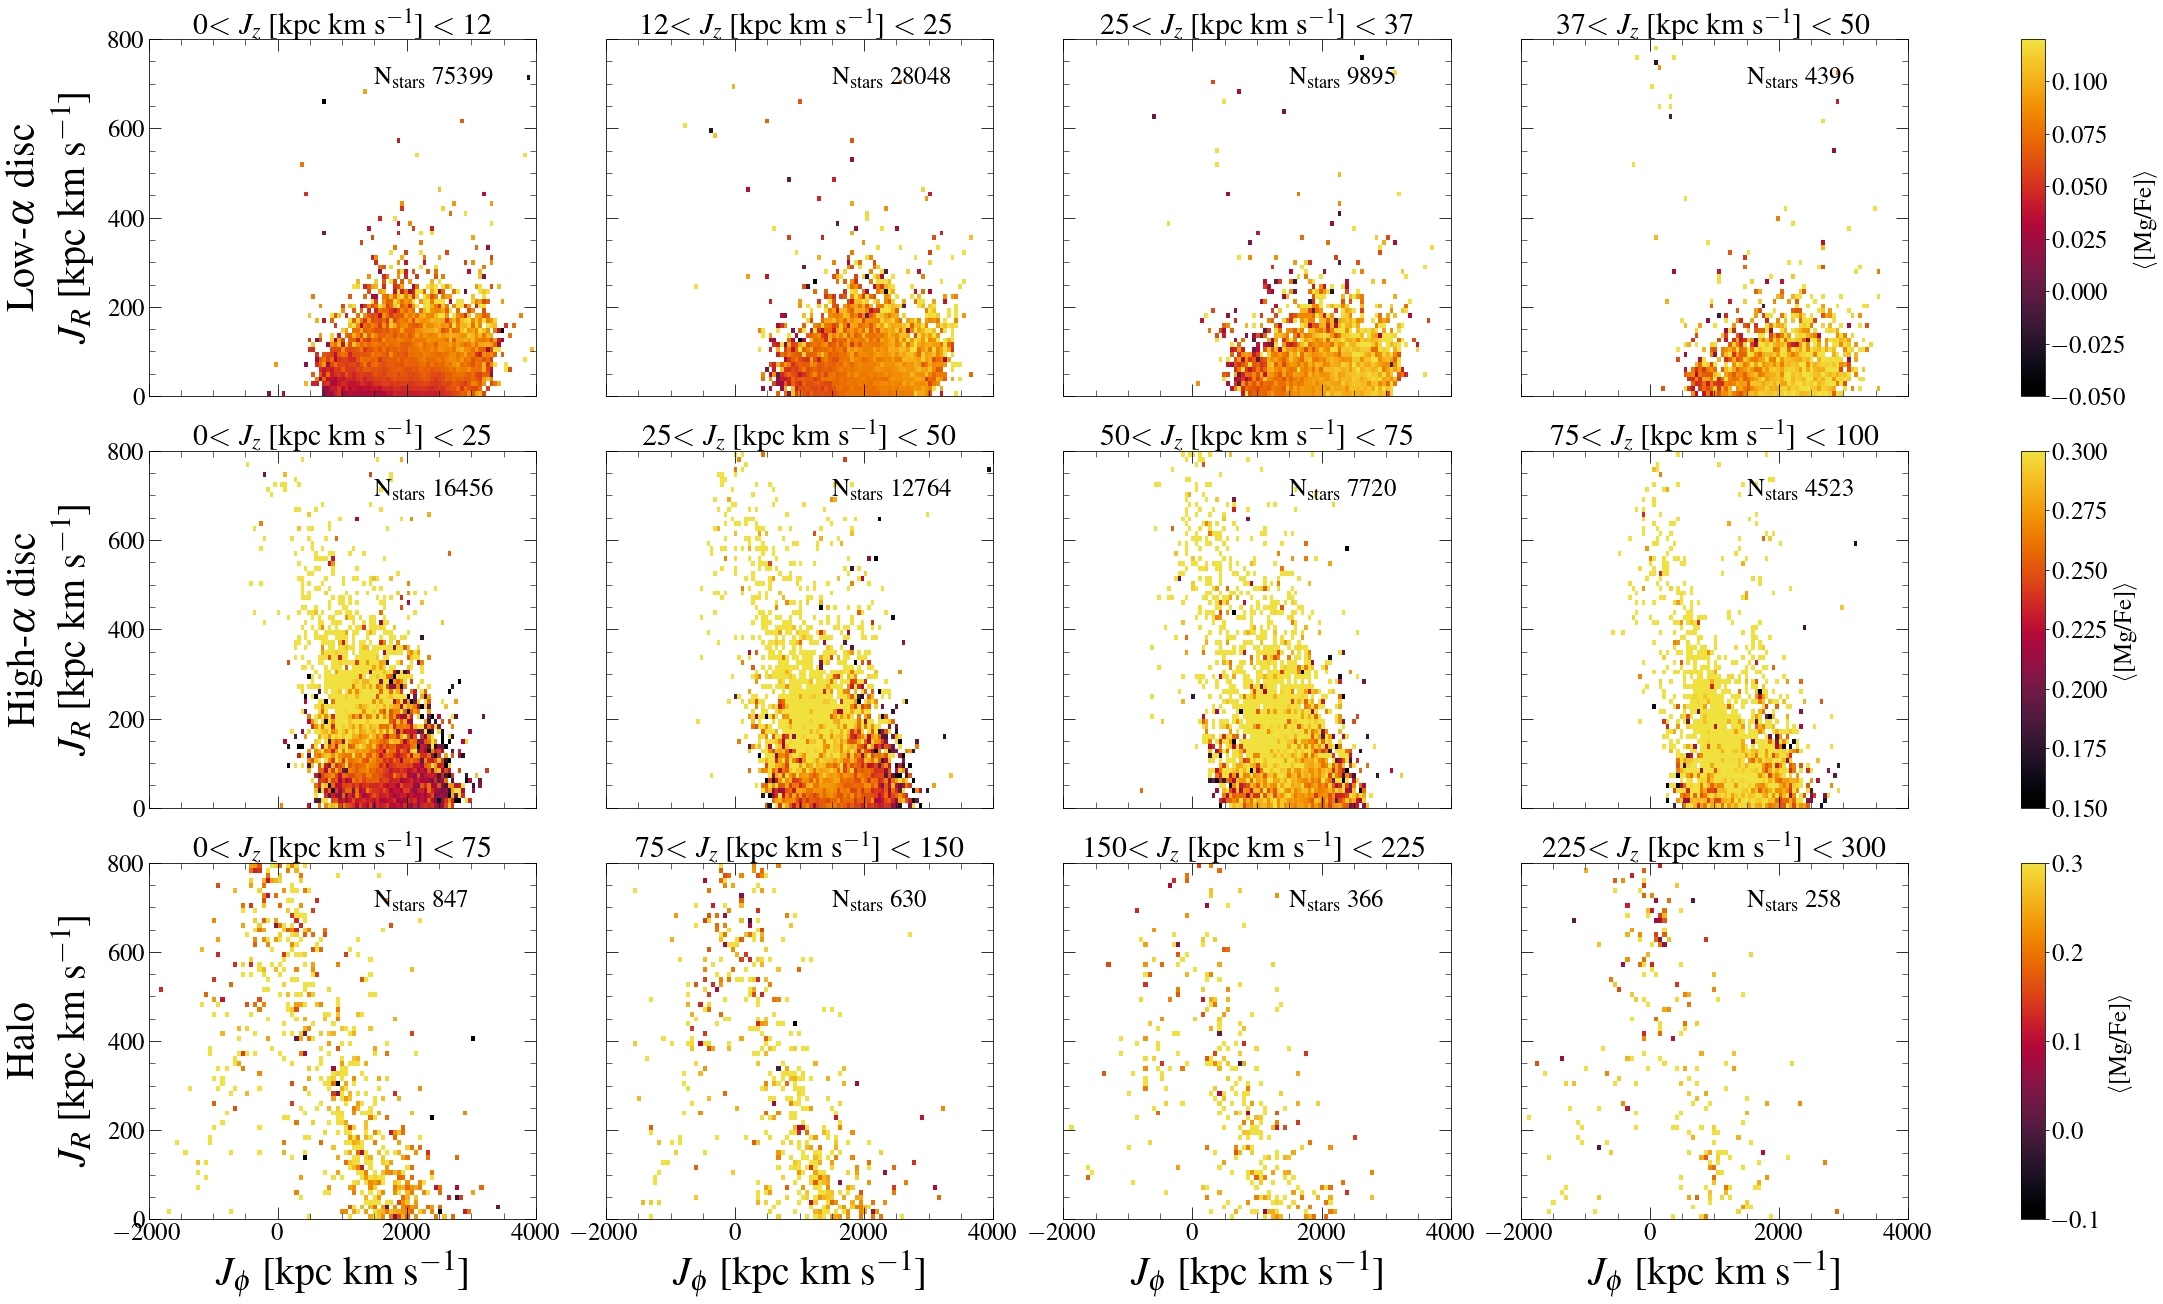

In [339]:
lowa =mask&lowa_disc_mask&(jr>0)&(jr<1e3)&(jphi>-5e3)&(jphi<5e3)&(jz>0)&(jz<50)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
higha = mask&higha_disc_mask&(jr>0)&(jr<1e3)&(jphi>-5e3)&(jphi<5e3)&(jz>0)&(jz<100)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))
halo = mask&other_mask&(jr>0)&(jr<1e3)&(jphi>-5e3)&(jphi<5e3)&(jz>0)&(jz<300)&(data['MG_FE']>-10)\
&(~np.isnan(data['MG_FE']))&(~np.isnan(jr))

plot_3_3(jz,jphi,jr,data['MG_FE'],lowa,higha,halo,label1=r'$J_{z}$ [kpc km s$^{-1}$]',\
         label2 = r'$J_{\phi}$ [kpc km s$^{-1}$]', label3=r'$J_{R}$ [kpc km s$^{-1}$]',\
            xlim1 = -2e3, xlim2 = 4e3, ylim1 =0, ylim2 = 800,xnstar = 1.5e3, ynstar = 700)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/actions-Jz-3x3.pdf',dpi=200, bbox_inches = 'tight')


# Orbits in $\alpha$-Fe plane

In [473]:
def plot_alpha_fe_var_dens(feh,alpha,var1,var2, feh_n = 8, alpha_n = 3,label1 = 'L$_{z}$',label2=r'E [km$^{2}~s$^{2}$]',\
                         xlim0=-3e3,xlim1=4e3,ylim0=-3e5,ylim1=0,nstarsx=3e3,nstarsy=-1e2):
    
    """
    Function to plot two variables (var1,var2) gridded in an alpha-fe plane
    
    INPUT: alpha, feh, variable 1, variable 2
    
    OUTPUT: Plot of var 1 vs var 2 in a grid of Rg and zmax
    
    """
    
    # split the Rg array into Rg_n bins (input 5)
    feh_bins = np.around(np.linspace(-2,0.5,feh_n+1),decimals=2)
    alpha_bins = np.flip(np.around(np.linspace(-0.2,0.4,alpha_n+1),decimals=2))
    
    # create the plot
    fig, all_axes = plt.subplots(alpha_n,feh_n, constrained_layout=True, figsize=(40, 15), sharex=True, sharey=True,rasterized=True)

    # loop over the grid
    for indx, i in enumerate(alpha_bins[:-1]):
        axis = all_axes[indx]
        for jndx, j in enumerate(feh_bins[:-1]):
            ax = axis[jndx]
            # create a mask for every loop
            mask_loop = (feh>j)&(feh<feh_bins[jndx+1])&(alpha<i)&(alpha>alpha_bins[indx+1])
            # make the plot
            ax.scatter(var1[mask_loop],var2[mask_loop],s=1,color='k')

            ax.set_xlim(xlim0,xlim1)
            ax.set_ylim(ylim0,ylim1)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
            ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20)


    all_axes[0,0].set_title(r'' +str('%5.2f' %feh_bins[0])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[1]),fontsize=25,pad=6)
    all_axes[0,1].set_title(r'' +str('%5.2f' %feh_bins[1])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[2]),fontsize=25,pad=6)
    all_axes[0,2].set_title(r'' +str('%5.2f' %feh_bins[2])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[3]),fontsize=25,pad=6)
    all_axes[0,3].set_title(r'' +str('%5.2f' %feh_bins[3])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[4]),fontsize=25,pad=6)
    all_axes[0,4].set_title(r'' +str('%5.2f' %feh_bins[4])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[5]),fontsize=25,pad=6)
    all_axes[0,5].set_title(r'' +str('%5.2f' %feh_bins[5])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[6]),fontsize=25,pad=6)
    all_axes[0,6].set_title(r'' +str('%5.2f' %feh_bins[6])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[7]),fontsize=25,pad=6)
    all_axes[0,7].set_title(r'' +str('%5.2f' %feh_bins[7])+ r'$<$ [Fe/H] $<$ '+str('%5.2f' %feh_bins[8]),fontsize=25,pad=6)

    all_axes[0,0].set_ylabel(r'' +str('%5.2f' %alpha_bins[0])+ r'$>$ [Mg/Fe] $>$ '+str('%5.2f' %alpha_bins[1])+' \n '+str(label2),fontsize=25,labelpad=6)
    all_axes[1,0].set_ylabel(r'' +str('%5.2f' %alpha_bins[1])+ r'$>$ [Mg/Fe] $>$ '+str('%5.2f' %alpha_bins[2])+' \n '+str(label2),fontsize=25,labelpad=6)
    all_axes[2,0].set_ylabel(r'' +str('%5.2f' %alpha_bins[2])+ r'$>$ [Mg/Fe] $>$ '+str('%5.2f' %alpha_bins[3])+' \n '+str(label2),fontsize=25,labelpad=6)
    
#     cbar = fig.colorbar(color, ax = axis, aspect=15)
#     cbar.set_label(label='N$_{\mathrm{stars}}$',fontsize=25)
#     cbar.ax.tick_params(labelsize=25)
    
    for ax in all_axes[-1]:
        ax.set_xlabel(label1,fontsize=25,labelpad=4)
#     for ax in all_axes[:, 0]:
#         ax.set_ylabel(label2,fontsize=30)

#     fig.savefig('../plots/rg-zmax-mgfe.pdf',dpi=150)


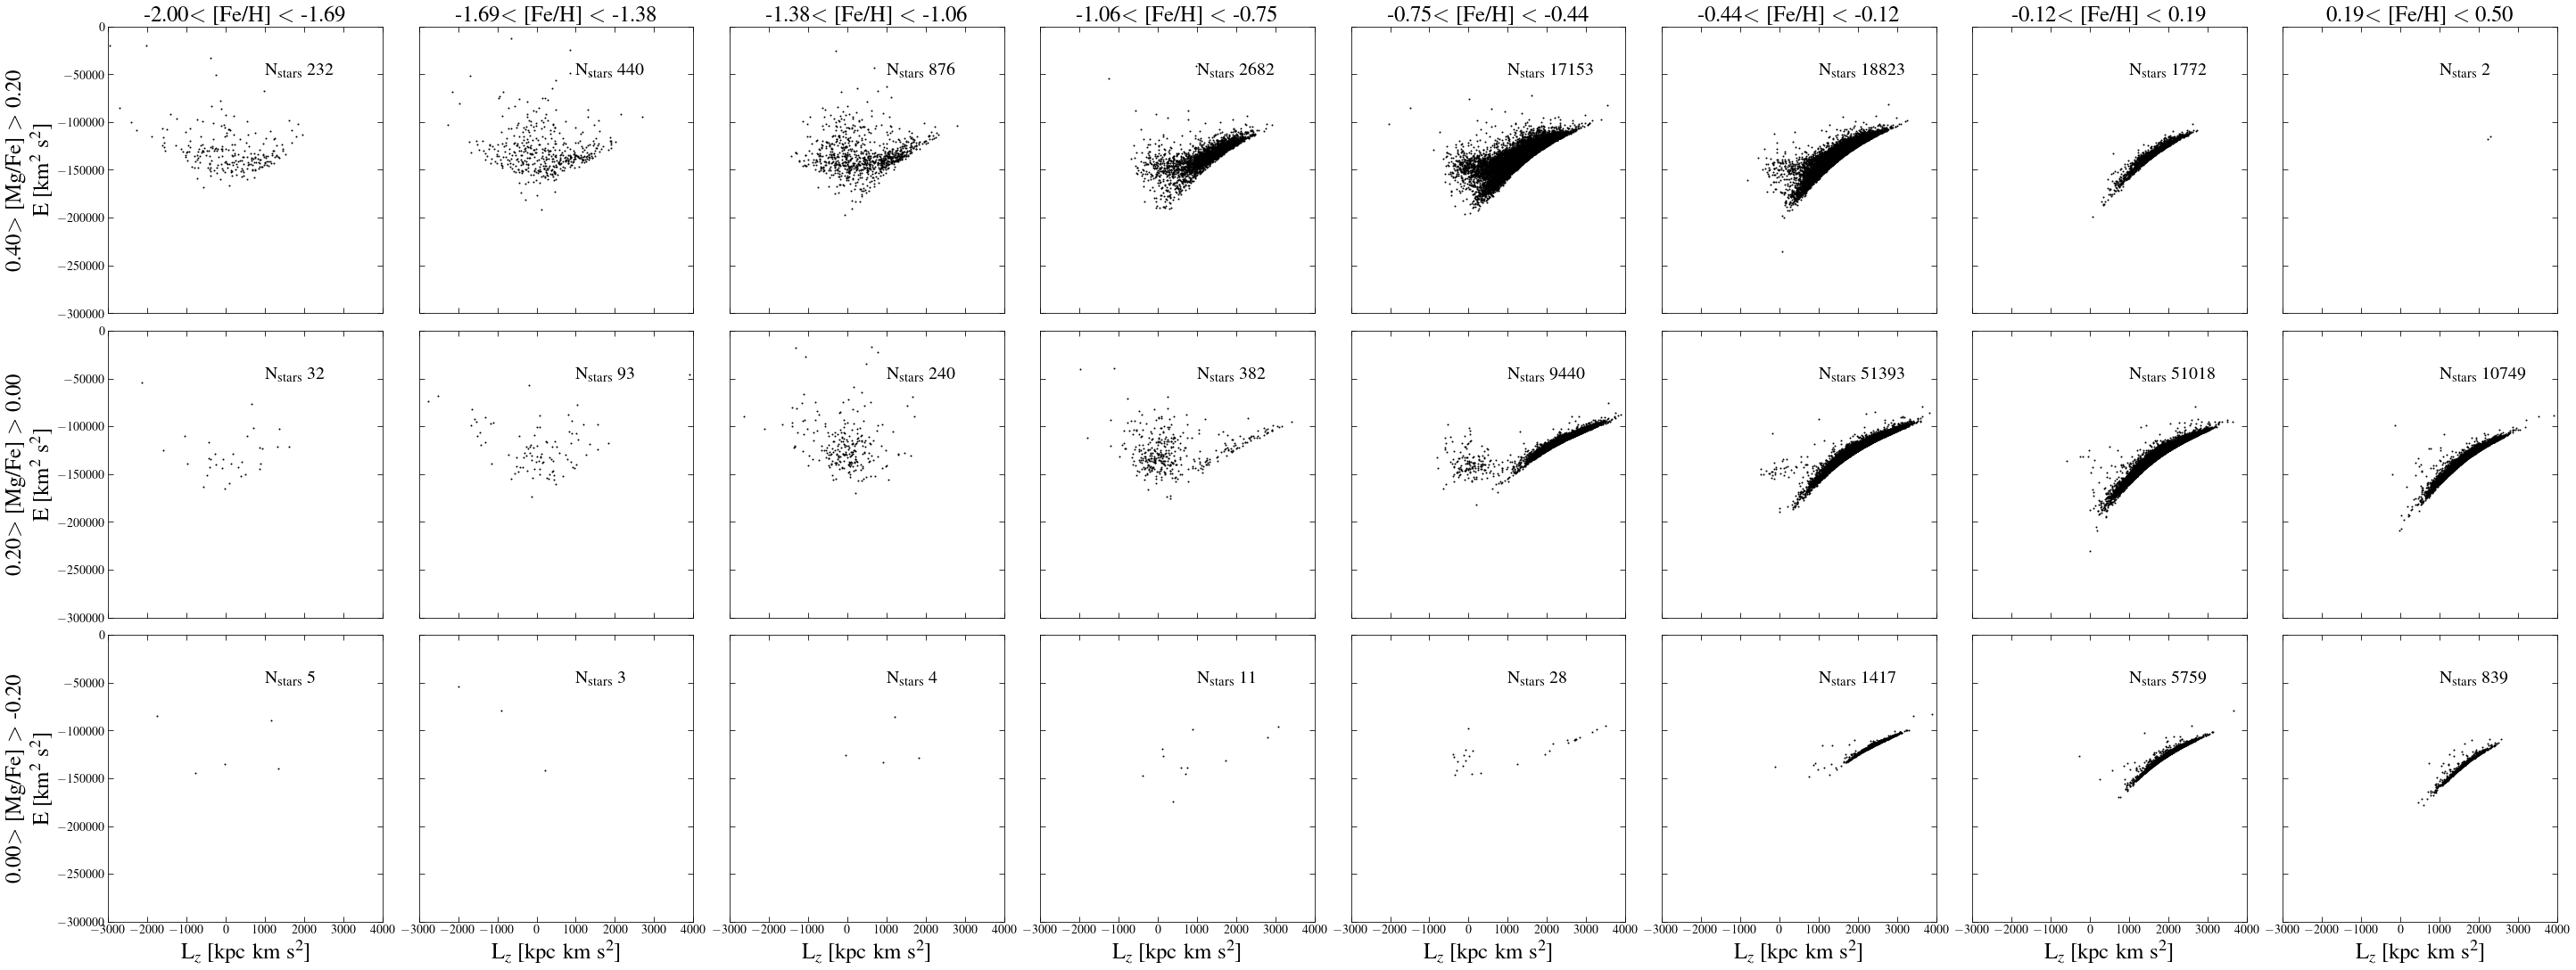

In [469]:
mask_plot = (data['L'][:,2]>-5e3)&(data['L'][:,2]<5e3)&(data['E']<0)&(data['E']>-5e5)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],(data['L'][:,2]*-1)[mask_plot],data['E'][mask_plot],\
                     label1=r'L$_{z}$ [kpc km s$^{2}$]',label2=r'E [km$^{2}$ s$^{2}$]',xlim0=-3e3,xlim1=4e3,ylim0=-3e5,\
                      ylim1=0,nstarsx=1e3,nstarsy=-5e4)

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/E-lz-tinsley.pdf',dpi=200, bbox_inches = 'tight')


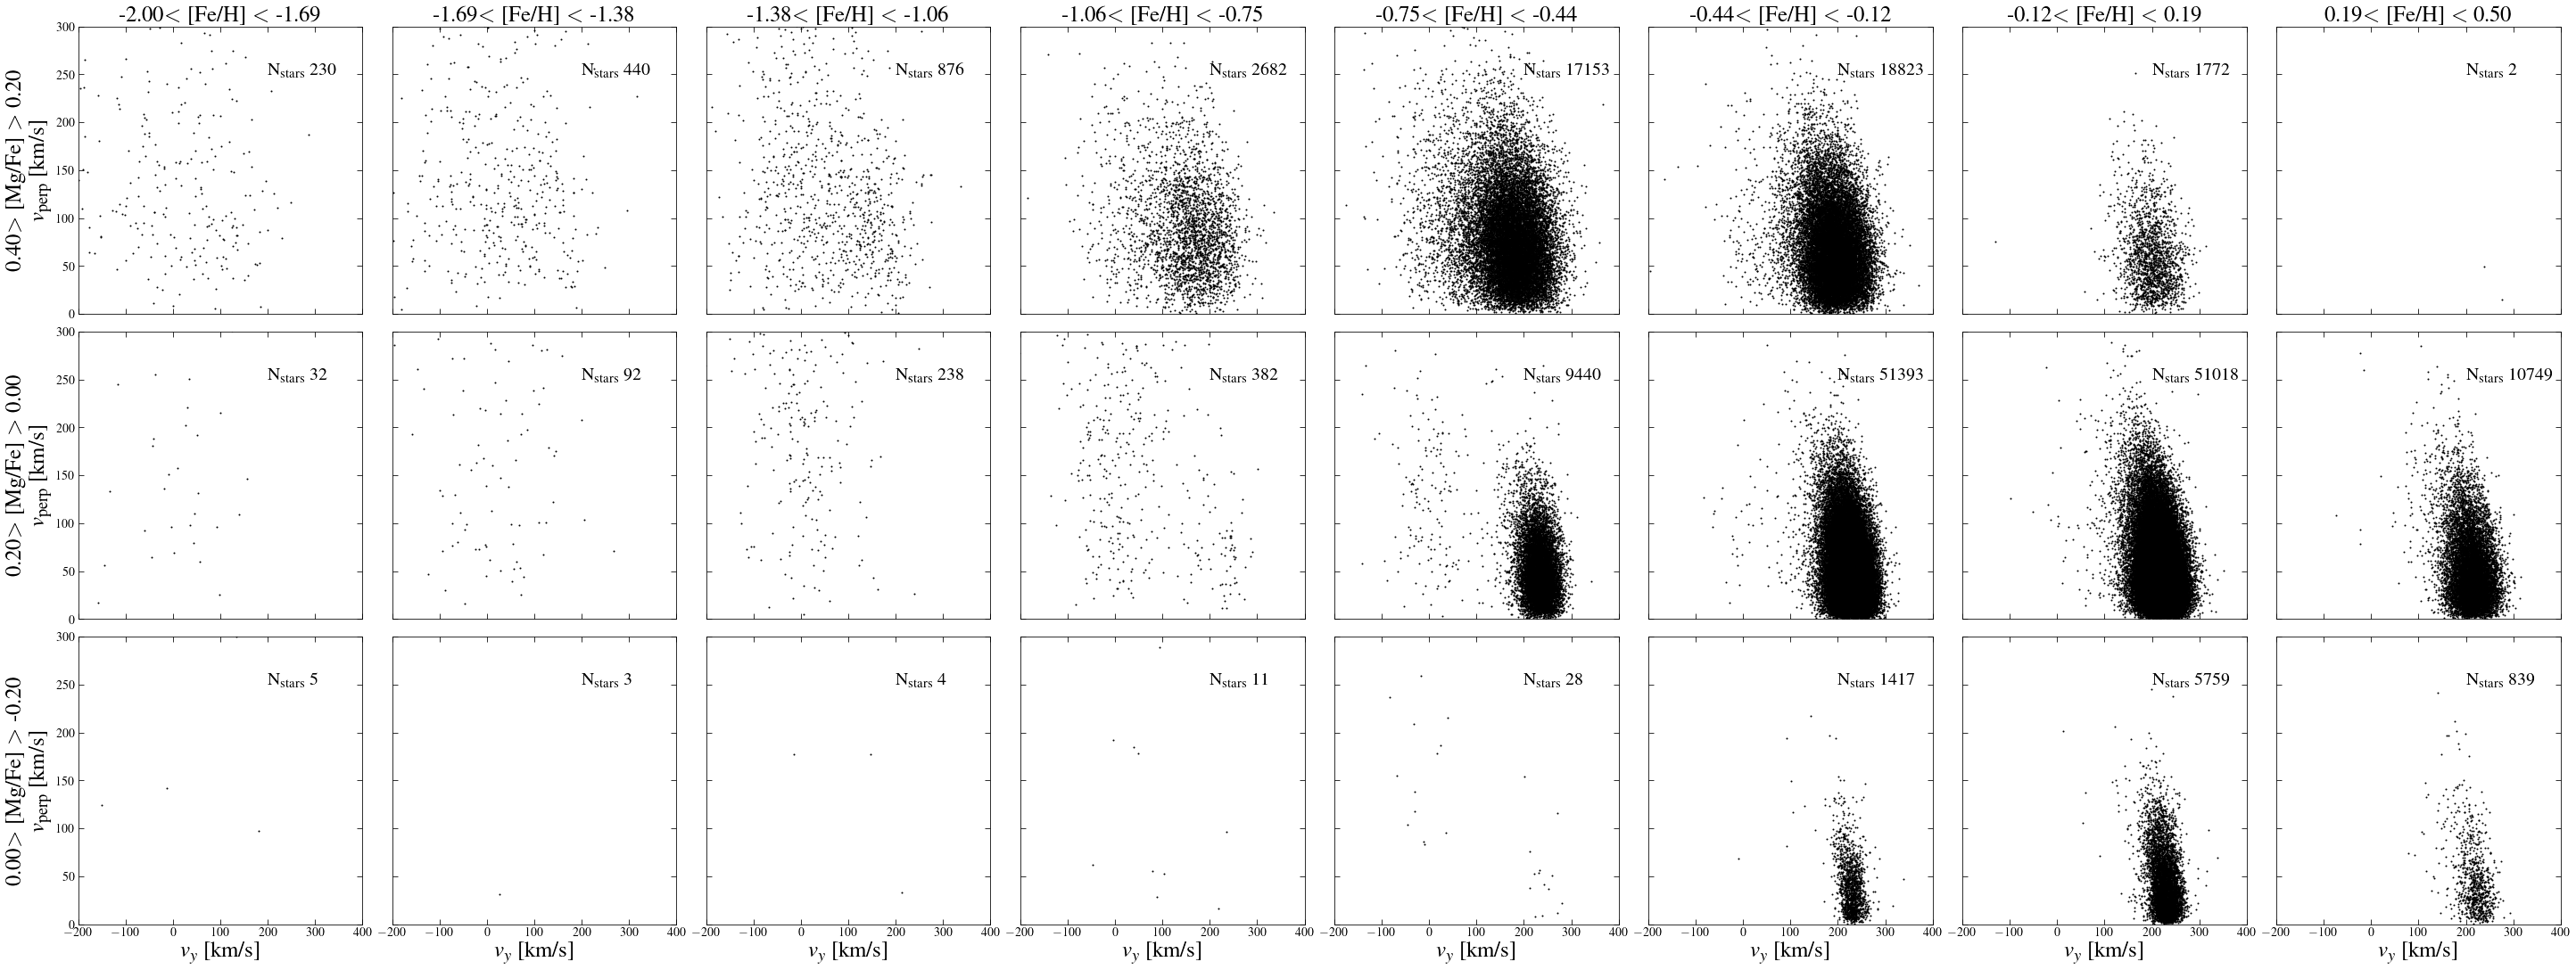

In [470]:
mask_plot = (np.abs(vxvz)<500)&(np.abs(vy)<400)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],vy[mask_plot],vxvz[mask_plot],\
                     label1=r'$v_y$ [km/s]',label2=r'$v_{\mathrm{perp}}$ [km/s]',\
                       xlim0=-200,xlim1=400,ylim0=0,ylim1=300,nstarsx=200,nstarsy=250)

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/toomre-tinsley.pdf',dpi=200, bbox_inches = 'tight')


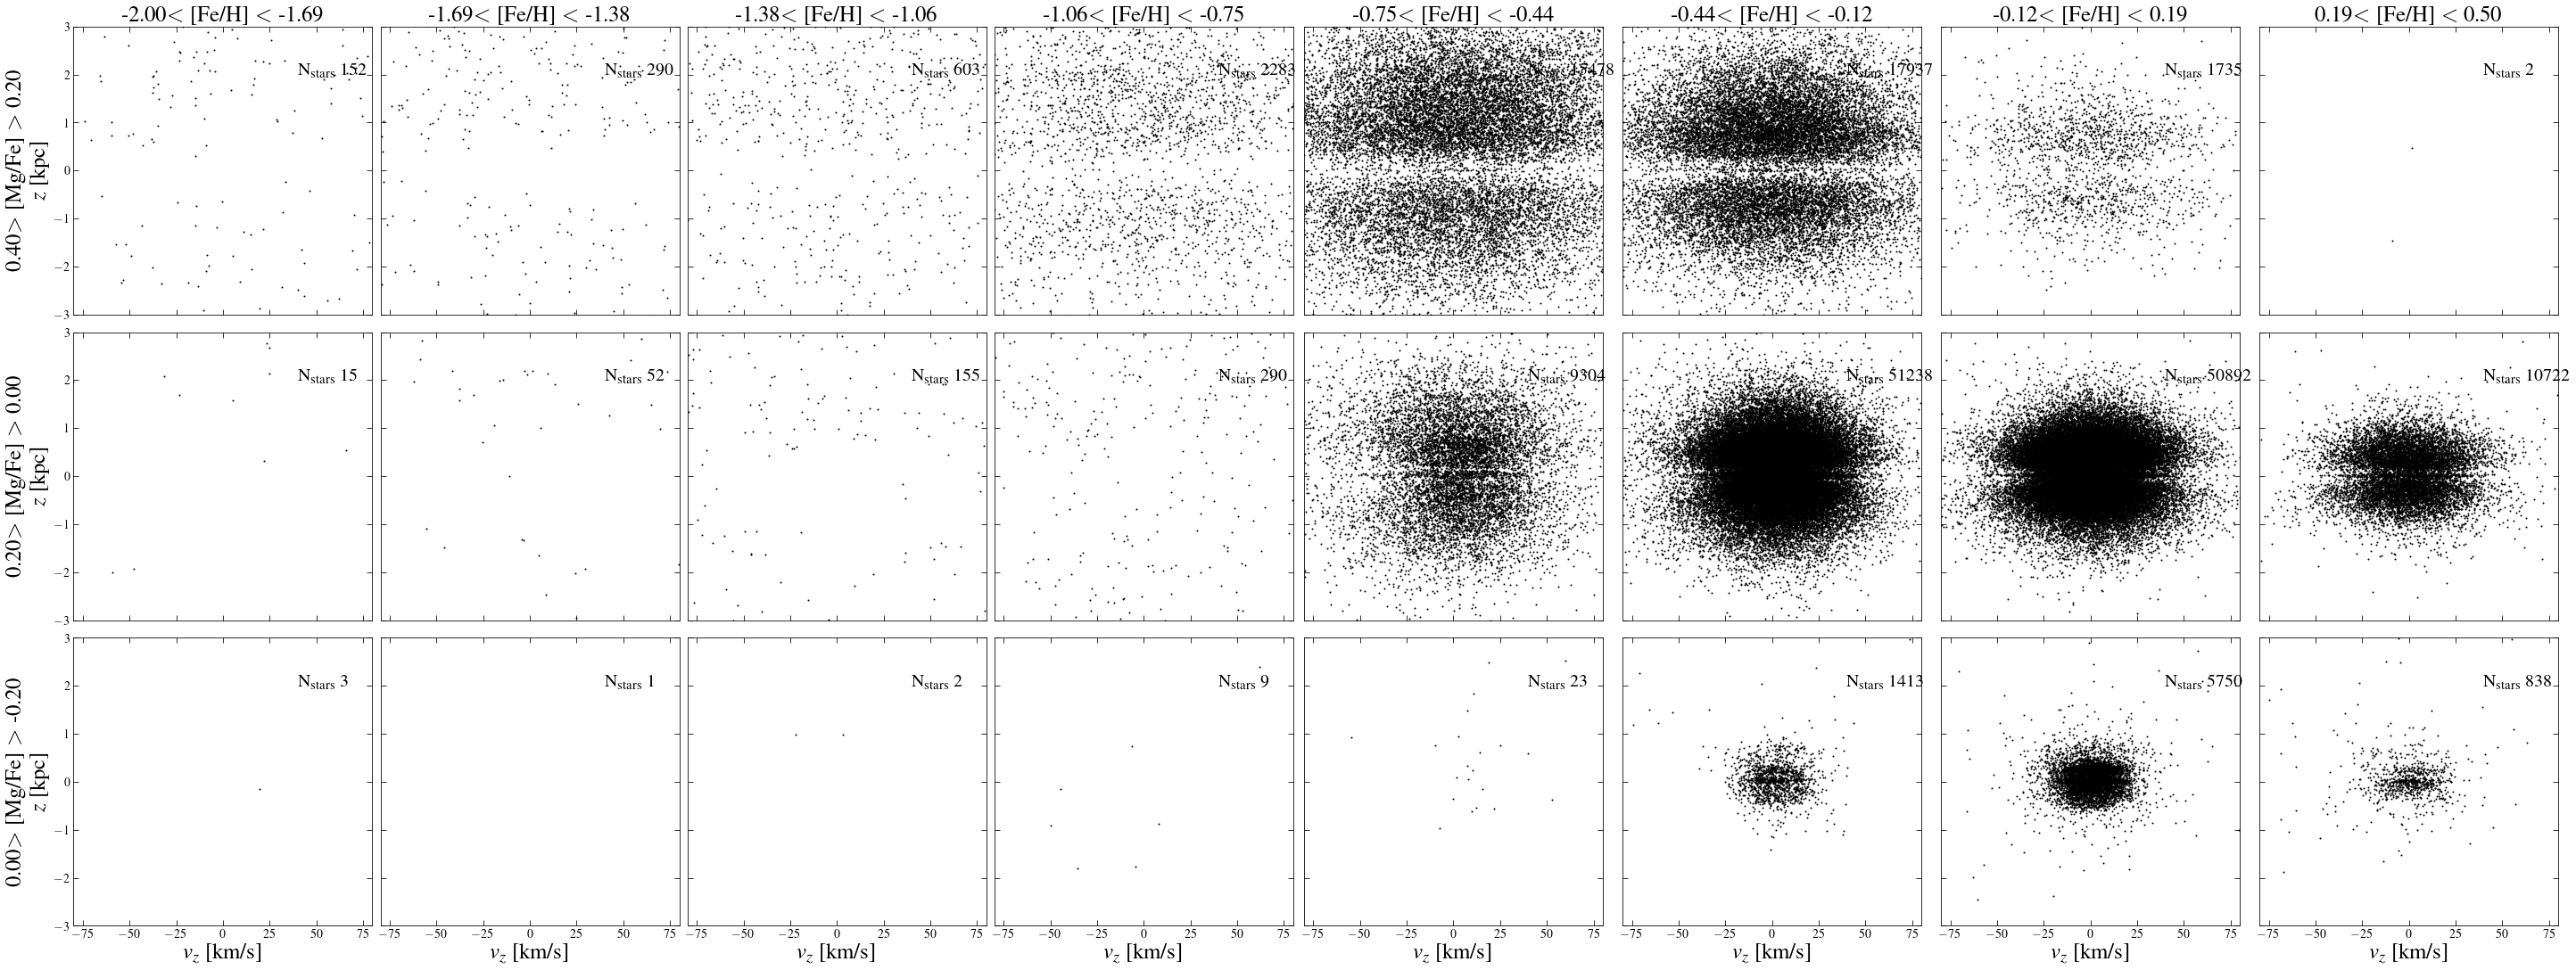

In [471]:
mask_plot = (np.abs(data['vxyz'][:,2])<80)&(np.abs(data['xyz'][:,2])<10)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['vxyz'][:,2][mask_plot],data['xyz'][:,2][mask_plot],\
                     label1=r'$v_z$ [km/s]',label2=r'$z$ [kpc]',\
                       xlim0=-80,xlim1=80,ylim0=-3,ylim1=3,nstarsx=40,nstarsy=2)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/vz-z-tinsley.pdf',dpi=200, bbox_inches = 'tight')


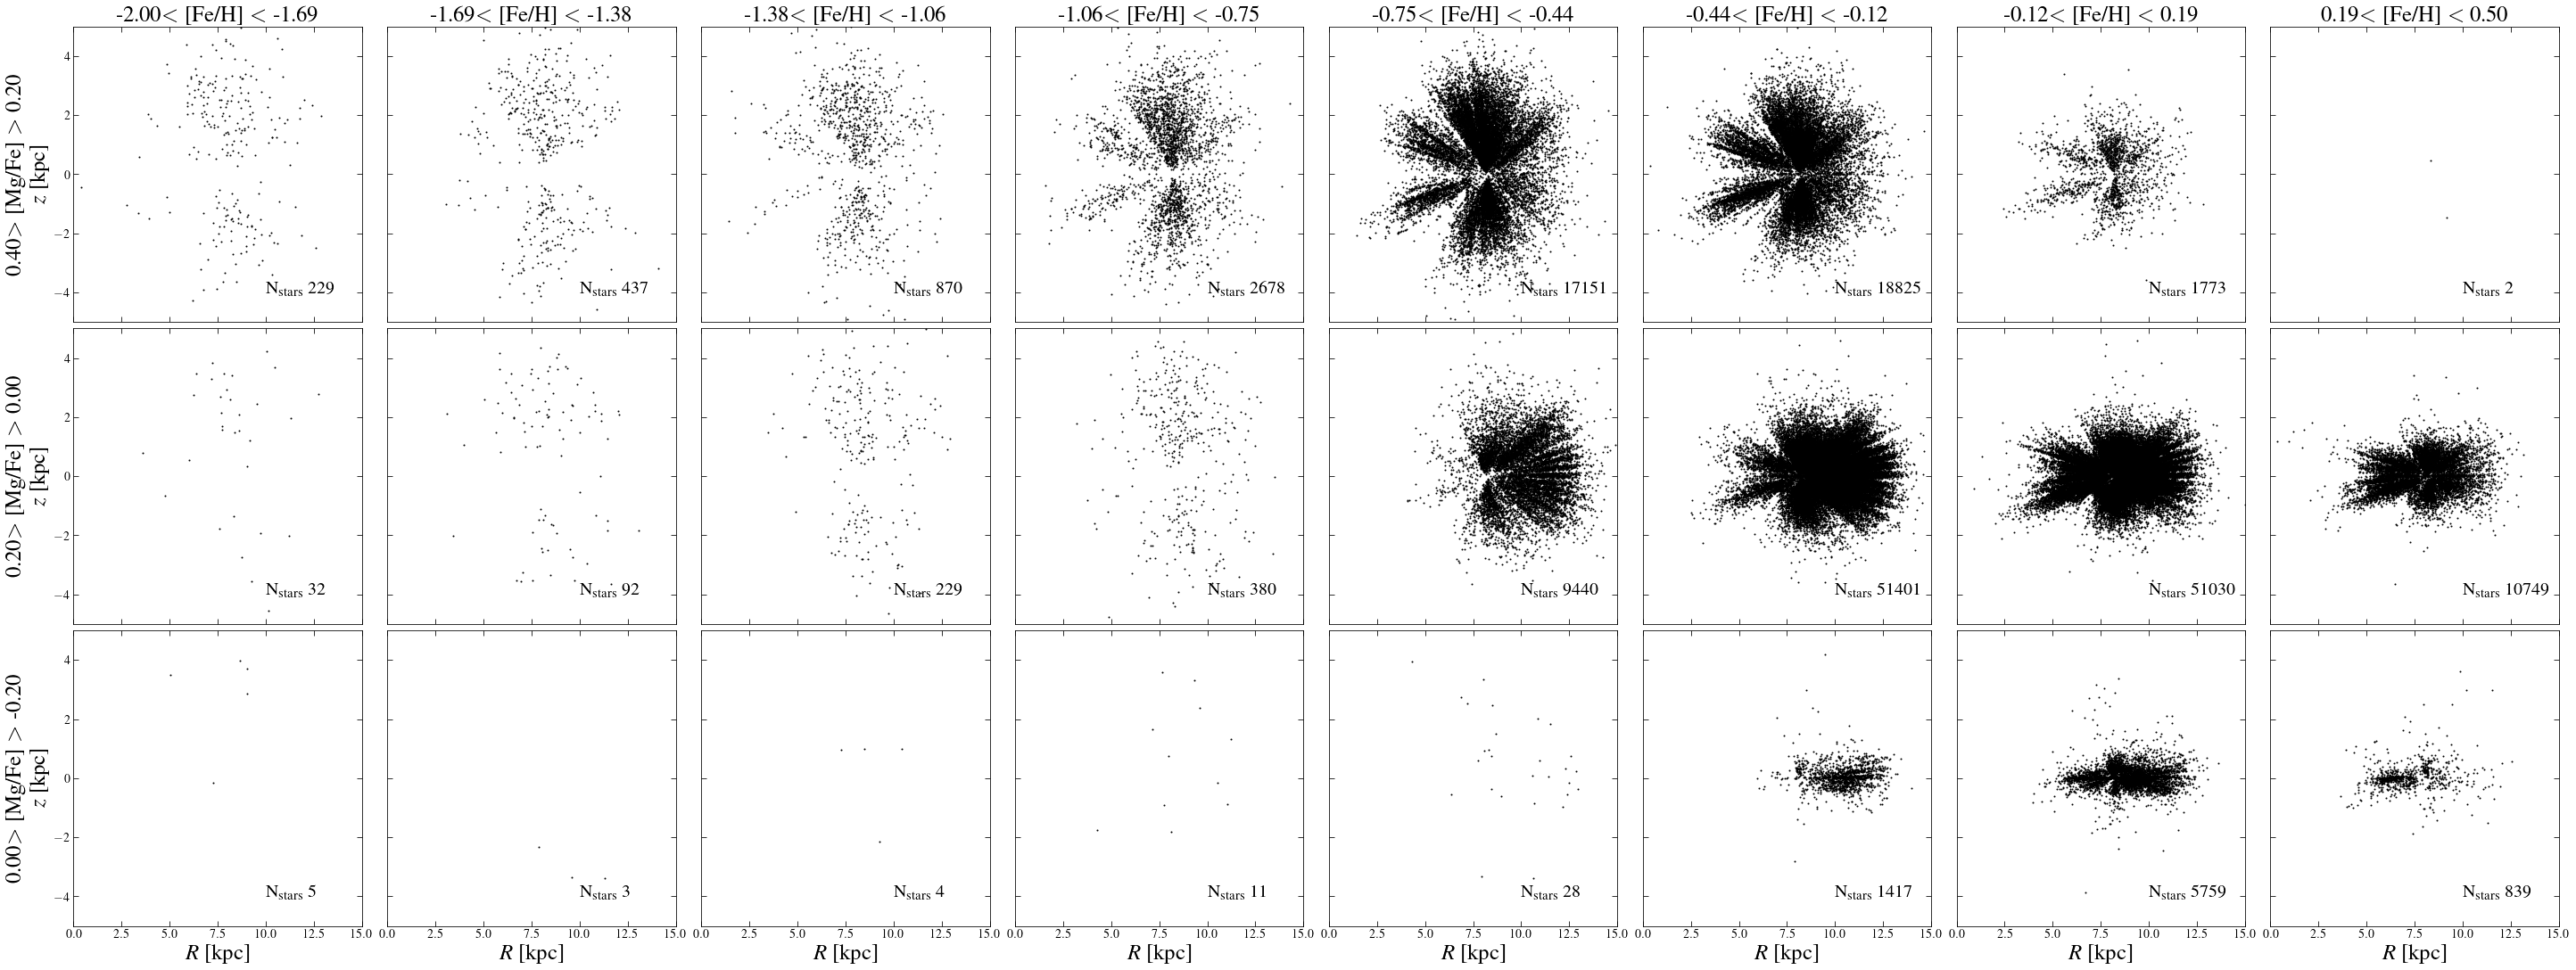

In [472]:
R = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
mask_plot = (np.abs(R)<20)&(np.abs(data['xyz'][:,2])<5)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],R[mask_plot],data['xyz'][:,2][mask_plot],\
                     label1=r'$R$ [kpc]',label2=r'$z$ [kpc]',\
                       xlim0=0,xlim1=15,ylim0=-5,ylim1=5,nstarsx=10,nstarsy=-4)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/R-z-tinsley.pdf',dpi=200, bbox_inches = 'tight')


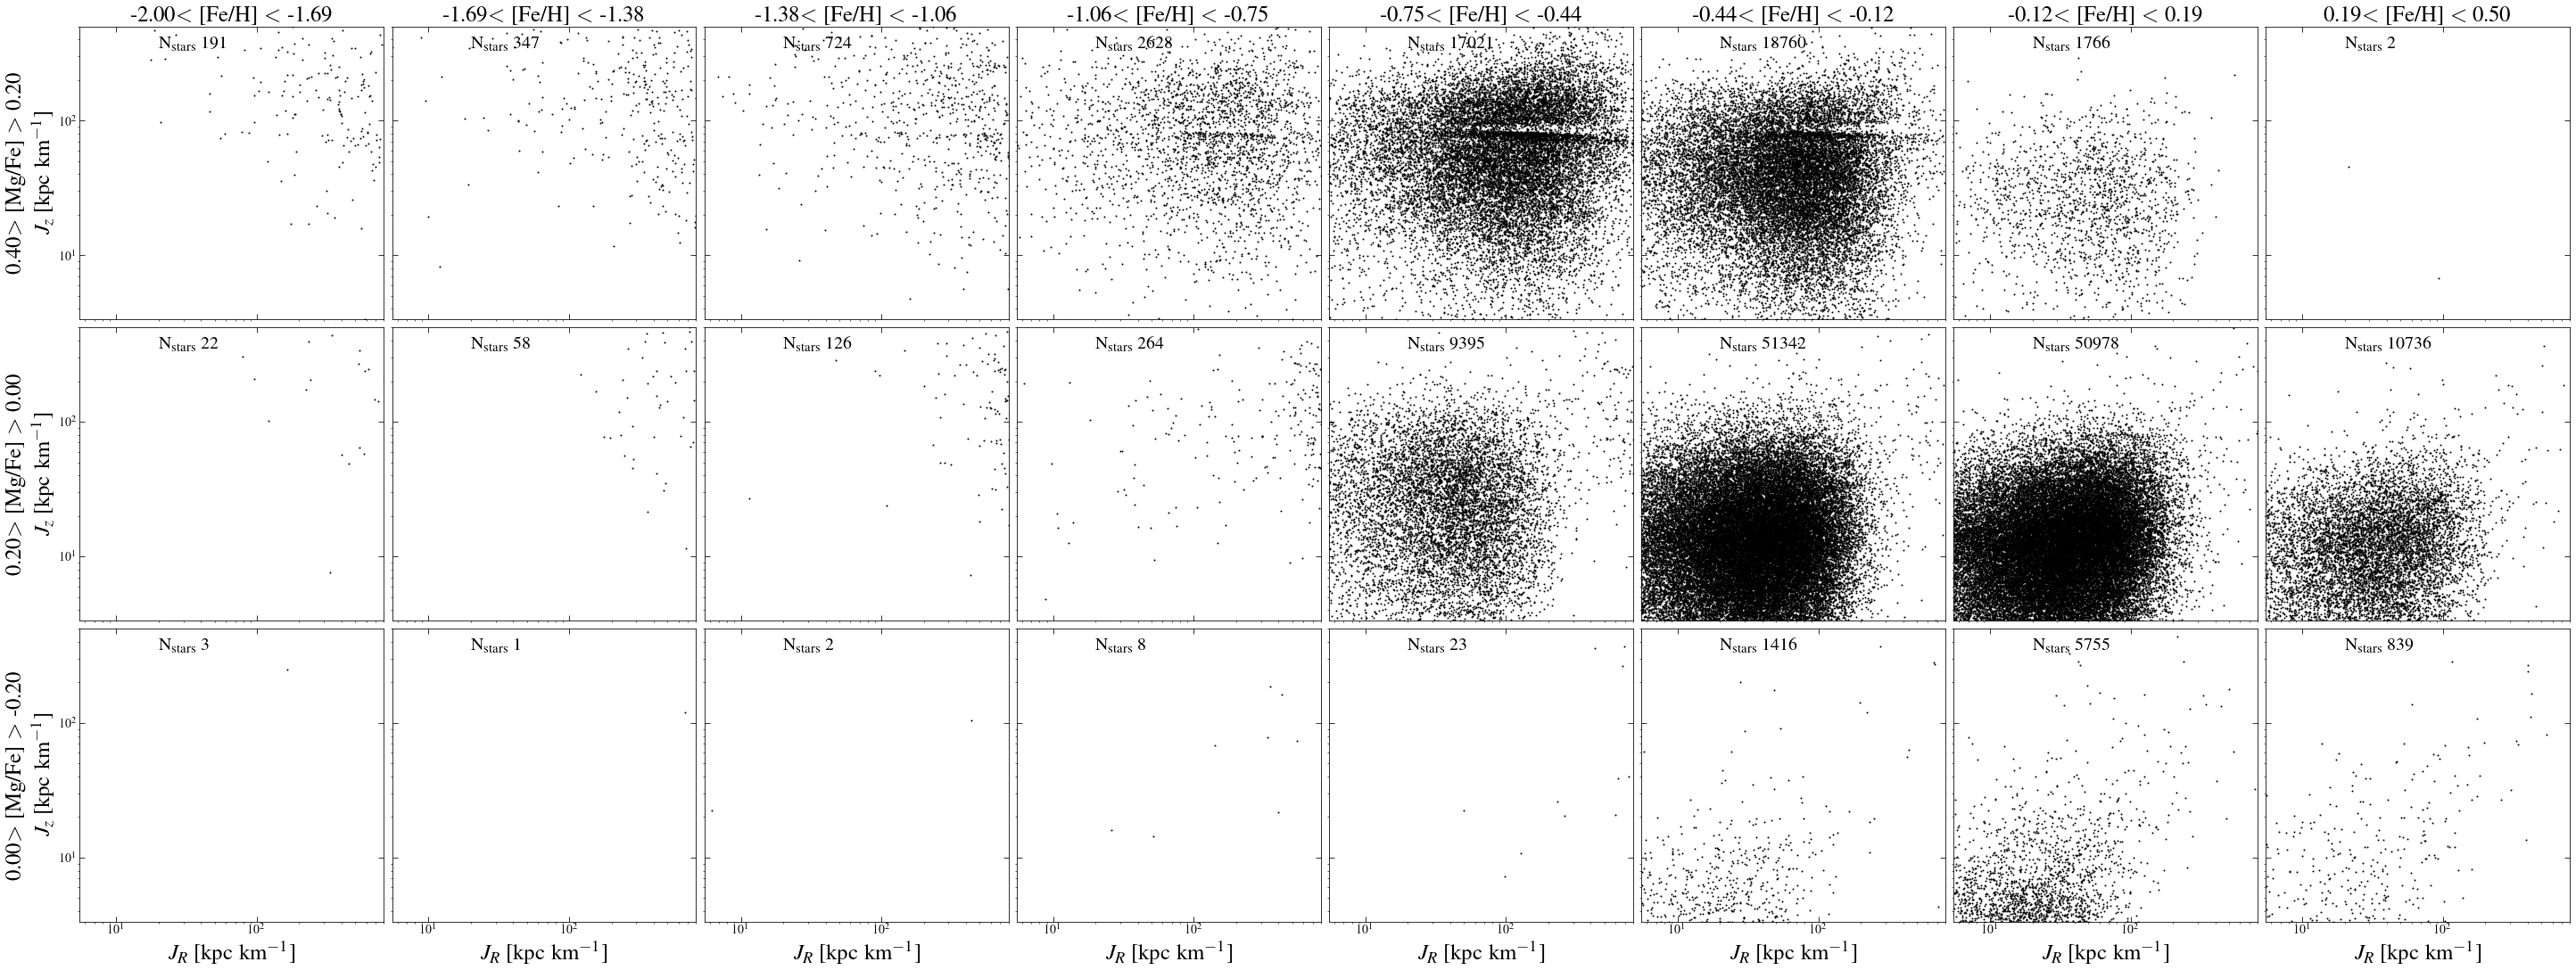

In [474]:
mask_plot = (np.abs(data['actions'][:,0])<1e3)&(np.abs(data['actions'][:,2])<1e3)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['actions'][:,0][mask_plot],\
                       data['actions'][:,2][mask_plot],label1=r'$J_{R}$ [kpc km$^{-1}$]',label2=r'$J_{z}$ [kpc km$^{-1}$]',\
                       xlim0=0,xlim1=800,ylim0=0,ylim1=500,nstarsx=20,nstarsy=350)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Jr-Jz-tinsley.pdf',dpi=200, bbox_inches = 'tight')


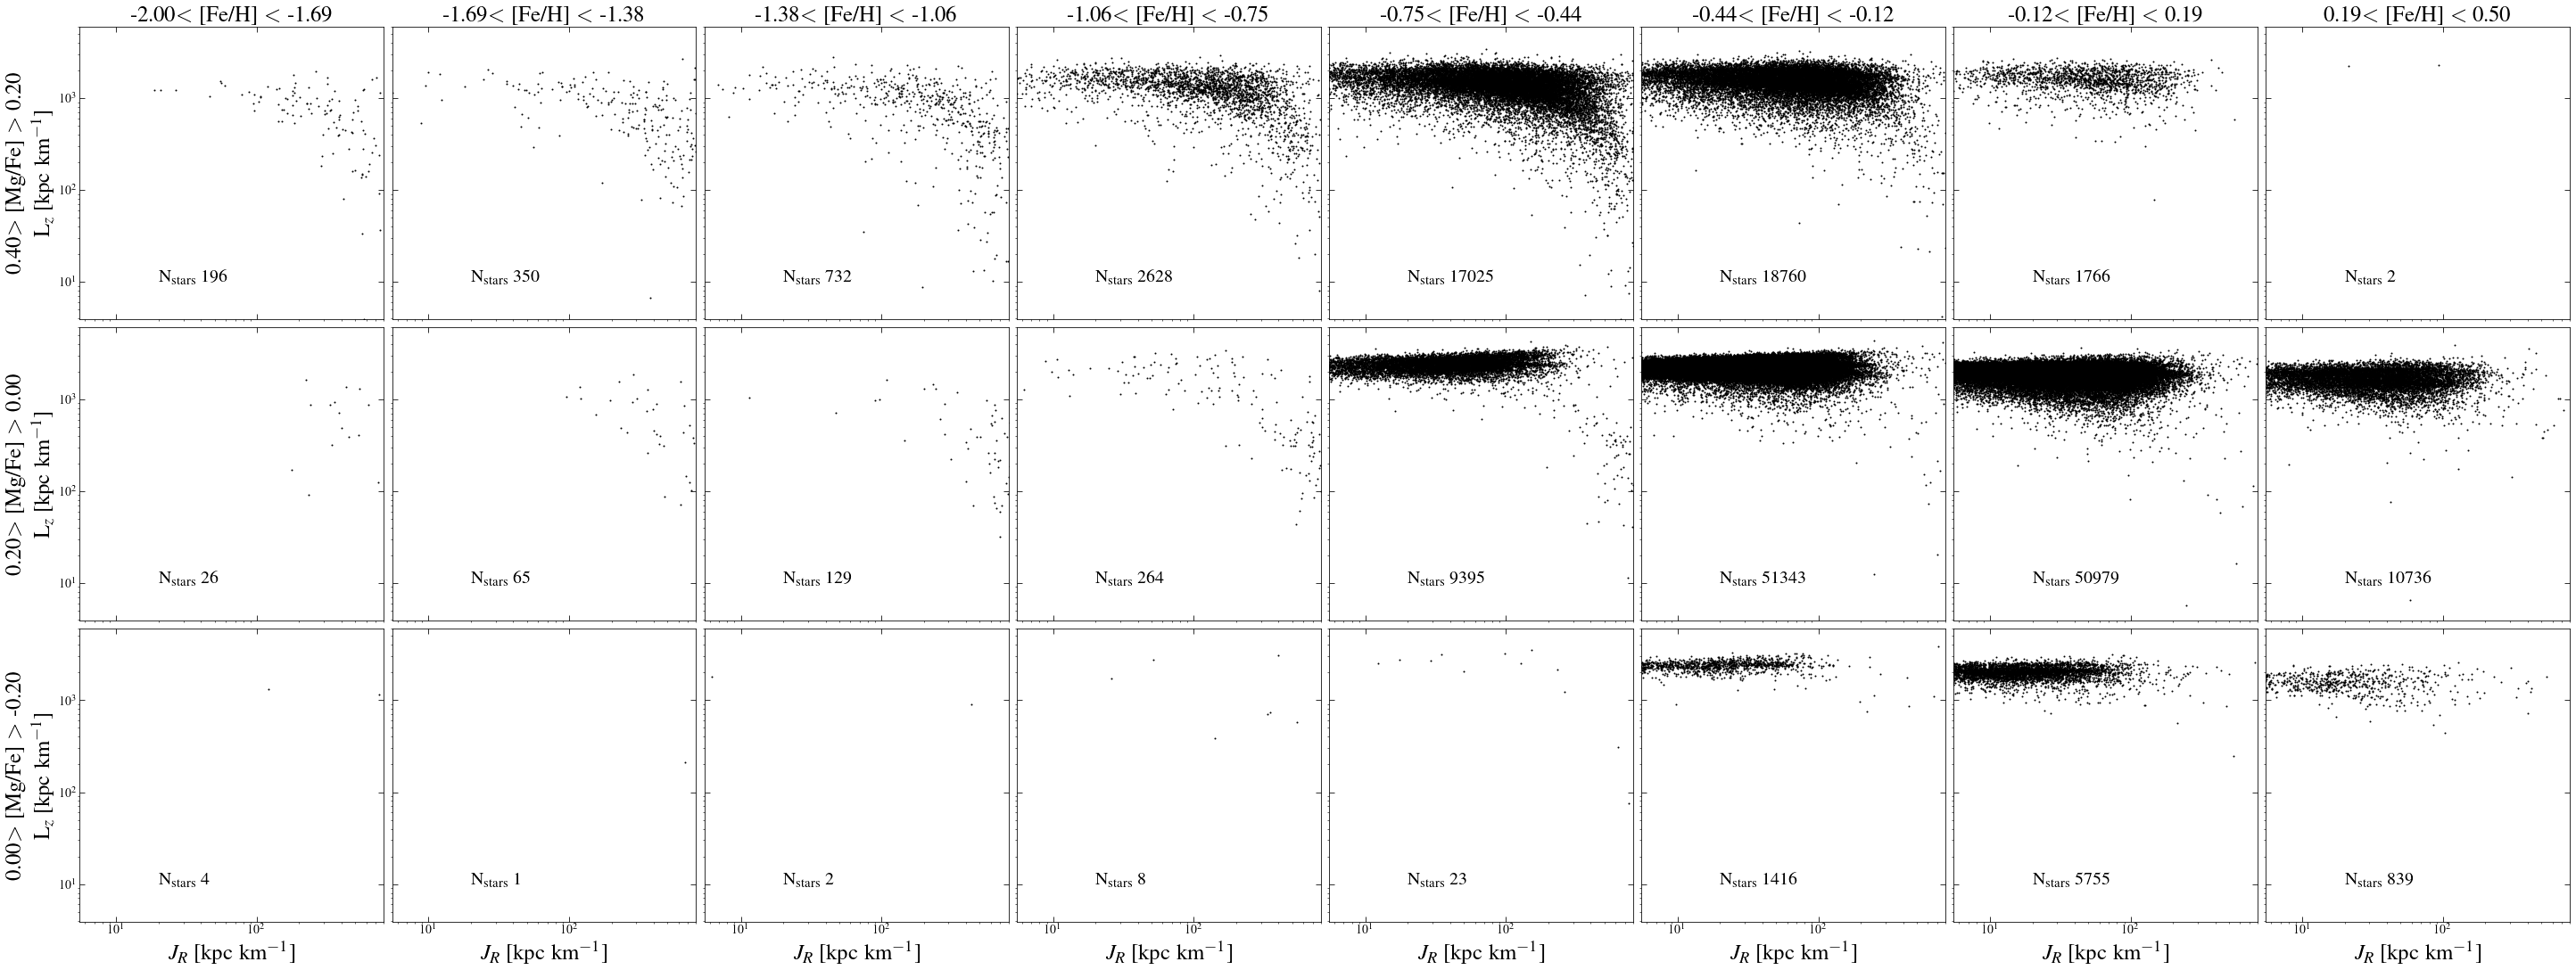

In [475]:
mask_plot = (np.abs(data['actions'][:,0])<1e3)&(np.abs(data['L'][:,2])<6e3)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['actions'][:,0][mask_plot],\
                       -data['L'][:,2][mask_plot],label1=r'$J_{R}$ [kpc km$^{-1}$]',label2=r'L$_{z}$ [kpc km$^{-1}$]',\
                       xlim0=0,xlim1=800,ylim0=-2e3,ylim1=6e3,nstarsx=20,nstarsy=10)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Jr-Lz-tinsley.pdf',dpi=200, bbox_inches = 'tight')


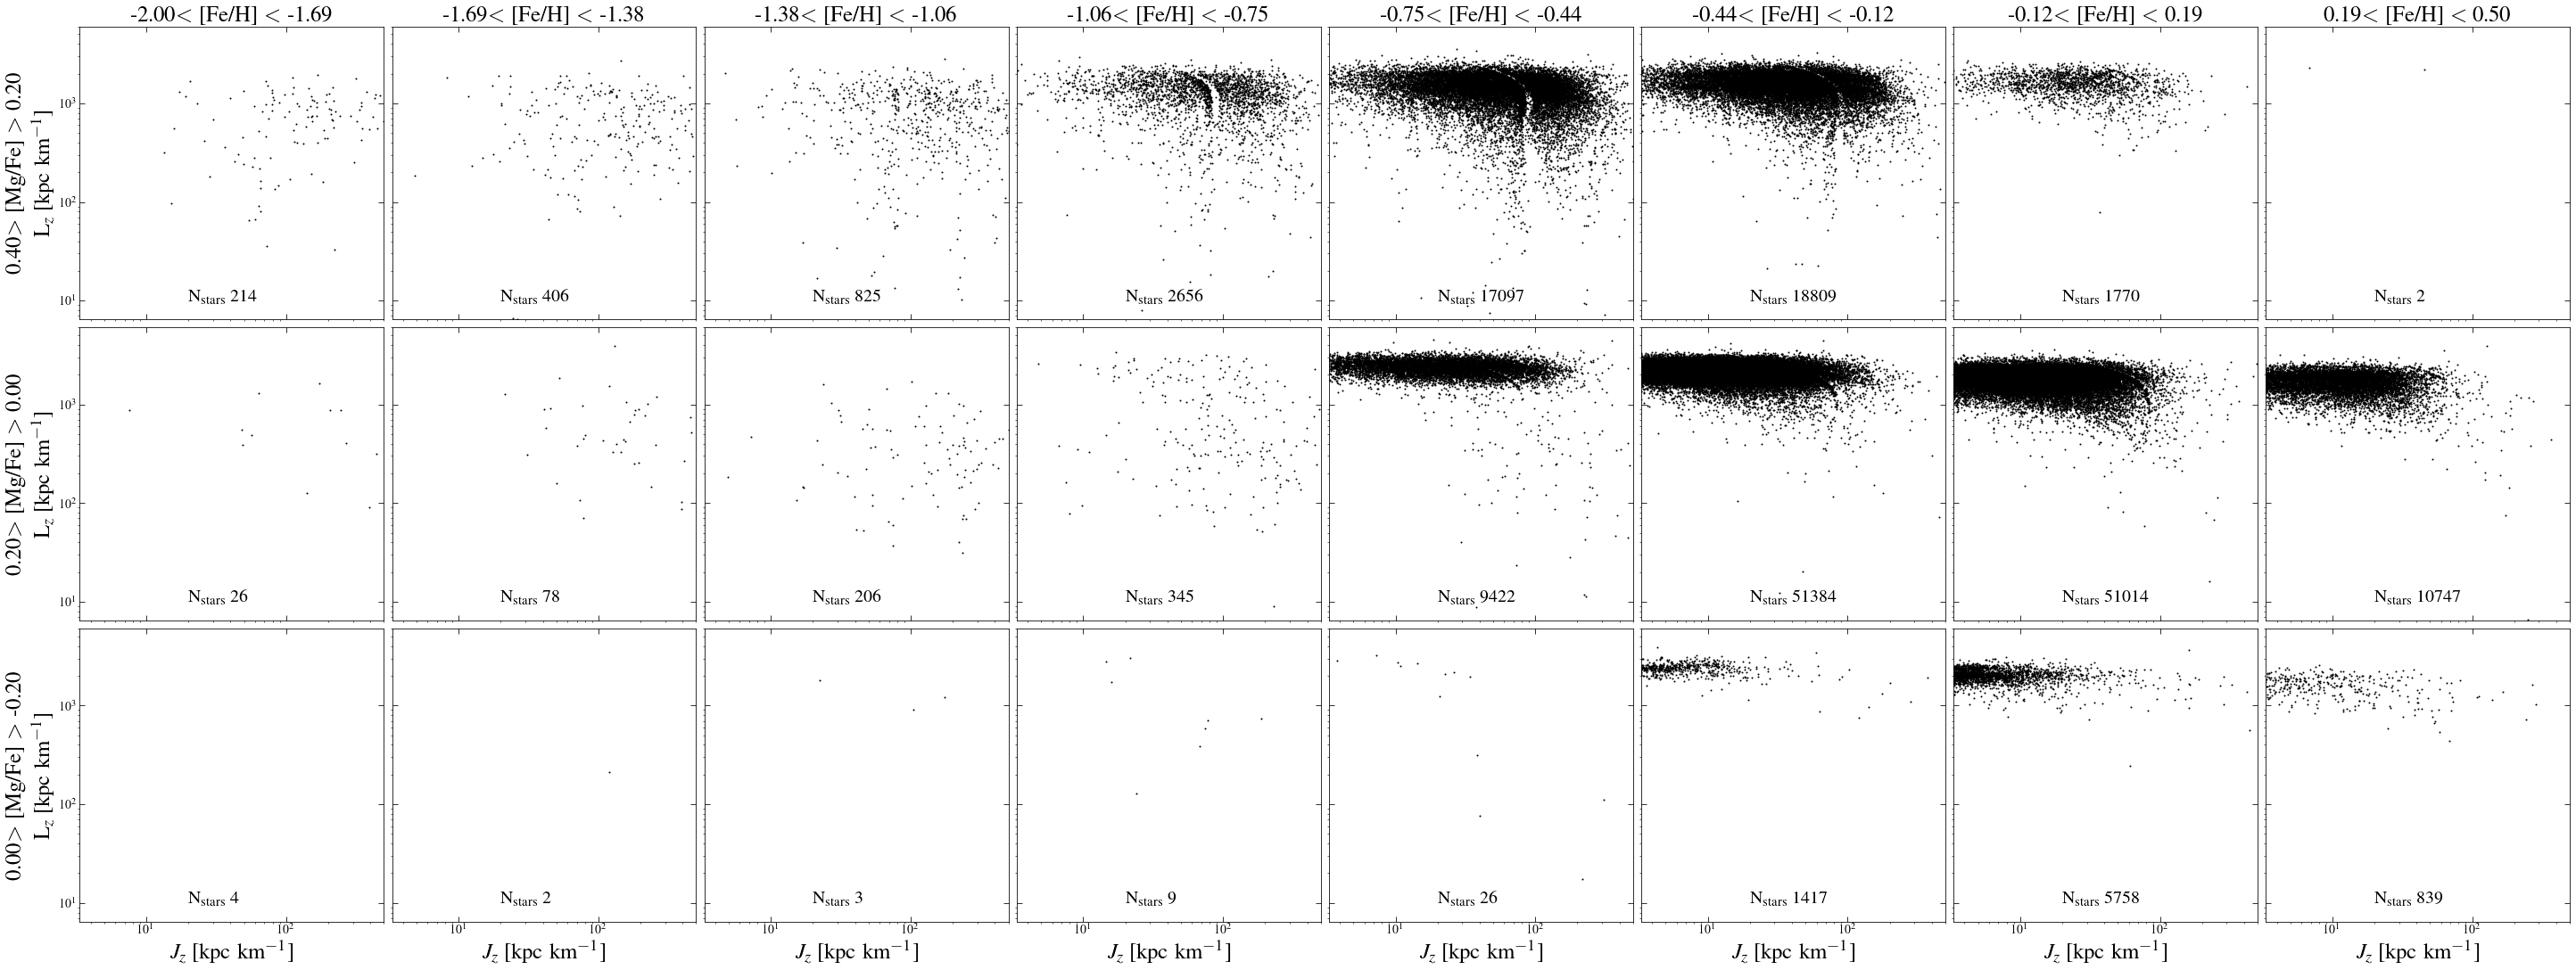

In [476]:
mask_plot = (np.abs(data['actions'][:,2])<1e3)&(np.abs(data['L'][:,2])<6e3)&\
            (np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_alpha_fe_var_dens(data['FE_H'][mask_plot],data['MG_FE'][mask_plot],data['actions'][:,2][mask_plot],\
                       -data['L'][:,2][mask_plot],label1=r'$J_{z}$ [kpc km$^{-1}$]',label2=r'L$_{z}$ [kpc km$^{-1}$]',\
                       xlim0=0,xlim1=500,ylim0=-2e3,ylim1=6e3,nstarsx=20,nstarsy=10)
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/Jz-Lz-tinsley.pdf',dpi=200, bbox_inches = 'tight')


In [198]:
print(len(data[mask&(phi>0)&(phi<180)&(Rg>4)&(Rg<6)]))

7098


In [477]:
def plot_Rg_zmax_var(Rg,zmax,var1,var2,var3, Rg_n = 5, zmax_n = 4,nbins=91,\
    stat='mean',label1 = '[Mg/H]',label2='[Fe/Mg]',xlim0=-1,xlim1=0.6,ylim0=-0.5,\
    ylim1=0.15,nstarsx=0.,nstarsy=-0.45, label3 = '[Mg/Fe]'):
    
    """
    Function to plot two variables (var1,var2) gridded in an Rg-zmax plane
    
    INPUT: Guiding-centre radius, maximum vertical height, variable 1, variable 2
    
    OUTPUT: Plot of var 1 vs var 2 in a grid of Rg and zmax
    
    """
    
    # split the Rg array into Rg_n bins (input 5)
    rg_bins = np.around(np.linspace(4,14,Rg_n+1),decimals=2)
    zmax_bins = np.flip(np.around(np.linspace(-45,45,zmax_n+1),decimals=2))

    # create the plot
    fig, all_axes = plt.subplots(zmax_n,Rg_n, constrained_layout=True, figsize=(30, 20), sharex=True, sharey=True,rasterized=True)

    # loop over the grid
    for indx, i in enumerate(zmax_bins[:-1]):
        axis = all_axes[indx]
        for jndx, j in enumerate(rg_bins[:-1]):
            ax = axis[jndx]
            
            # create a mask for every loop
            mask_loop = (Rg>j)&(Rg<rg_bins[jndx+1])&(zmax<i)&(zmax>zmax_bins[indx+1])
            
            if len(Rg[mask_loop])>0:
                # make the plot
                binx = np.linspace(-80,80,nbins)
                biny = np.linspace(-2,2,nbins)
                hist = stats.binned_statistic_2d(var1[mask_loop],var2[mask_loop], var3[mask_loop], statistic=stat, bins=[binx,biny])
                plot_x, plot_y = np.meshgrid(binx,biny) 
                color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=0.,vmax=0.12)

                ax.set_xlim(xlim0,xlim1)
                ax.set_ylim(ylim0,ylim1)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
                ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20)
            else:
#                 ax.scatter(0,0,s=0.1)
                ax.set_xlim(xlim0,xlim1)
                ax.set_ylim(ylim0,ylim1)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
                ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20)
                
    cbar = fig.colorbar(color, ax = all_axes, aspect=15)
    cbar.set_label(label=label3,fontsize=25)
    cbar.ax.tick_params(labelsize=25)


    all_axes[0,0].set_title(r'' +str('%5.2f' %rg_bins[0])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[1]),fontsize=25,pad=6)
    all_axes[0,1].set_title(r'' +str('%5.2f' %rg_bins[1])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[2]),fontsize=25,pad=6)
    all_axes[0,2].set_title(r'' +str('%5.2f' %rg_bins[2])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[3]),fontsize=25,pad=6)
    all_axes[0,3].set_title(r'' +str('%5.2f' %rg_bins[3])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[4]),fontsize=25,pad=6)
    all_axes[0,4].set_title(r'' +str('%5.2f' %rg_bins[4])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[5]),fontsize=25,pad=6)
#     all_axes[0,5].set_title(r'' +str('%5.2f' %rg_bins[5])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[6]),fontsize=25,pad=6)

    all_axes[0,0].set_ylabel(r'' +str('%5.2f' %zmax_bins[0])+ r'$>$ $\phi$ [$^{\circ}$] $>$ '+str('%5.2f' %zmax_bins[1])+' \n '+str(label2),fontsize=25,labelpad=6)
    all_axes[1,0].set_ylabel(r'' +str('%5.2f' %zmax_bins[1])+ r'$>$ $\phi$ [$^{\circ}$] $>$ '+str('%5.2f' %zmax_bins[2])+' \n '+str(label2),fontsize=25,labelpad=6)
    all_axes[2,0].set_ylabel(r'' +str('%5.2f' %zmax_bins[2])+ r'$>$ $\phi$ [$^{\circ}$] $>$ '+str('%5.2f' %zmax_bins[3])+' \n '+str(label2),fontsize=25,labelpad=6)
    all_axes[3,0].set_ylabel(r'' +str('%5.2f' %zmax_bins[3])+ r'$>$ $\phi$ [$^{\circ}$] $>$ '+str('%5.2f' %zmax_bins[4])+' \n '+str(label2),fontsize=25,labelpad=6)
    
#     cbar = fig.colorbar(color, ax = axis, aspect=15)
#     cbar.set_label(label='N$_{\mathrm{stars}}$',fontsize=25)
#     cbar.ax.tick_params(labelsize=25)
    
#     for ax in all_axes[-1]:
#         ax.set_xlabel(label1,fontsize=25,labelpad=4)

#     fig.savefig('../plots/lowa_Rg_zmax',dpi=150,format='png', rasterized=True)


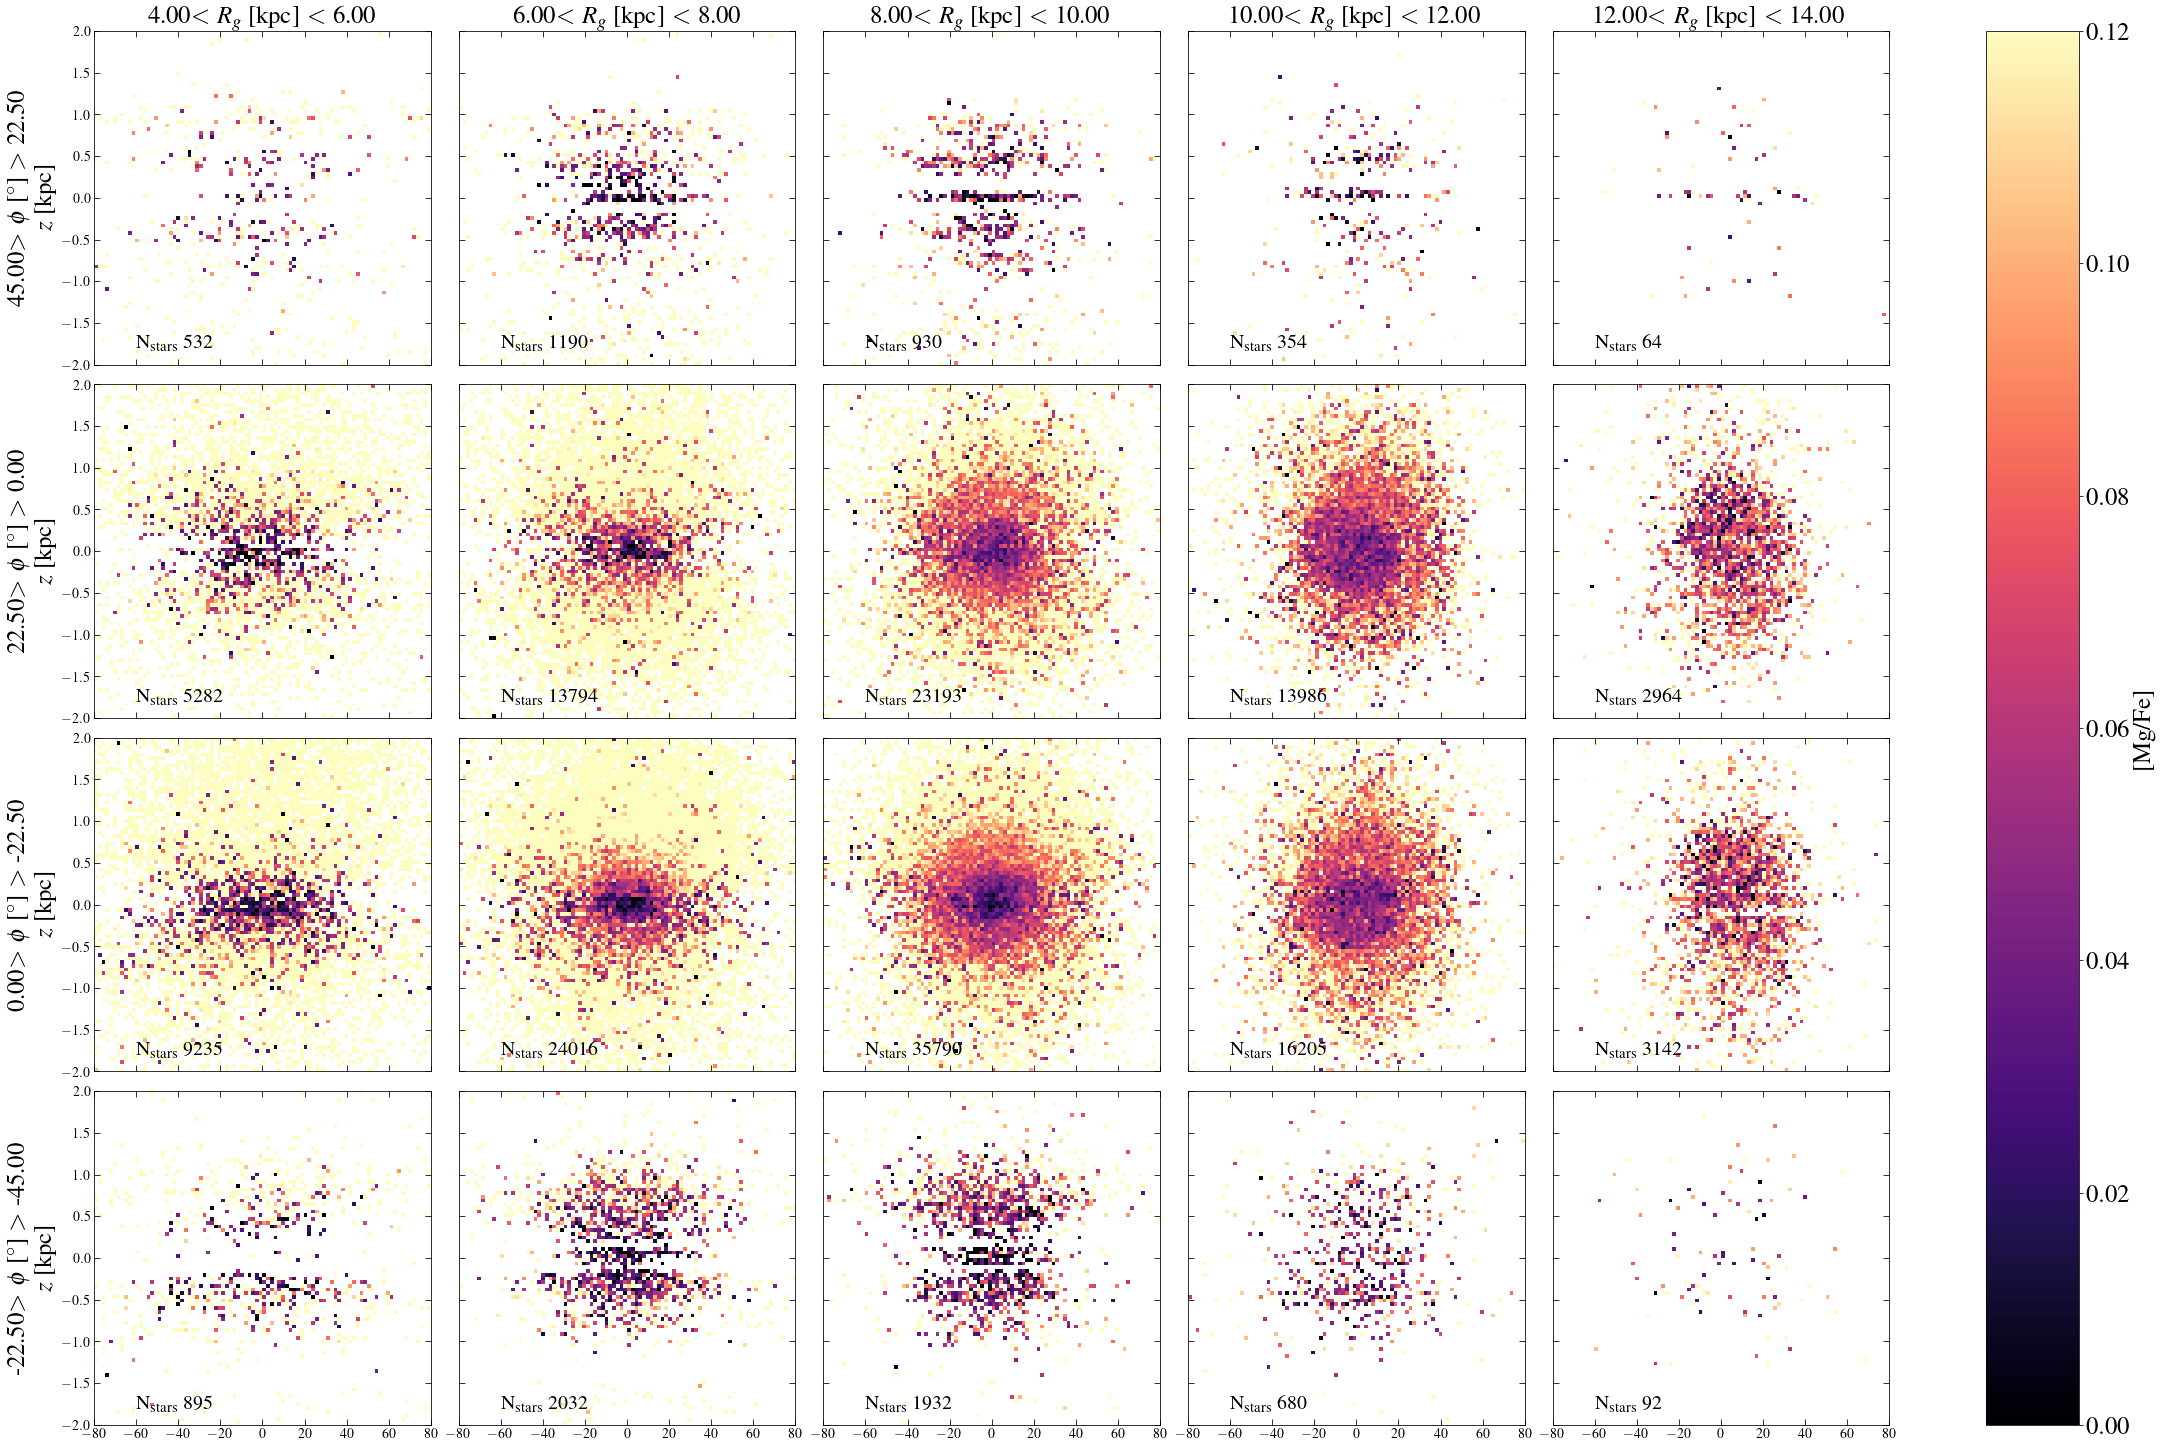

In [478]:
phi_deg = phi*180/np.pi

mask_plot = (Rg>4)&(Rg<14)&(phi_deg>-45)&(phi_deg<45)&(np.abs(data['xyz'][:,2])<2)&(np.abs(data['vxyz'][:,2])<80)\
                &(np.abs(data['MG_FE'])<1)&mask

plot_Rg_zmax_var(Rg[mask_plot],phi_deg[mask_plot],data['vxyz'][:,2][mask_plot],data['xyz'][:,2][mask_plot],data['MG_FE'][mask_plot],\
                     label1='$v_{z}$ [km s$^{-1}$]',label2='$z$ [kpc]',xlim0=-80,xlim1=80,ylim0=-2,ylim1=2,\
                     nstarsx=-60,nstarsy=-1.8,label3='[Mg/Fe]')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/vz-z-Rg-phi.pdf',dpi=200, bbox_inches = 'tight')


# Angle-$R_{g}$ binned by $z_{\mathrm{max}}$

In [289]:
angle_phi = data['angles'][:,1]*180/np.pi

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 6.7200e+02,
        3.1908e+04, 1.6133e+04, 1.9450e+03, 1.3340e+03, 1.9000e+01]),
 array([-0.60302711, -0.49152508, -0.38002306, -0.26852107, -0.15701905,
        -0.04551703,  0.06598499,  0.177487  ,  0.28898901,  0.40049103,
         0.51199305]),
 <BarContainer object of 10 artists>)

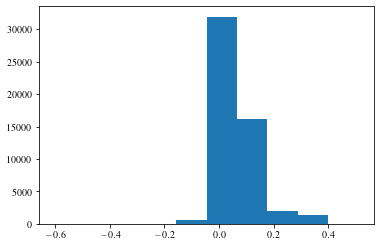

In [318]:
plt.hist(data['MG_FE'][mask_plot&(data['z_max']>0)&(data['z_max']<0.5)])

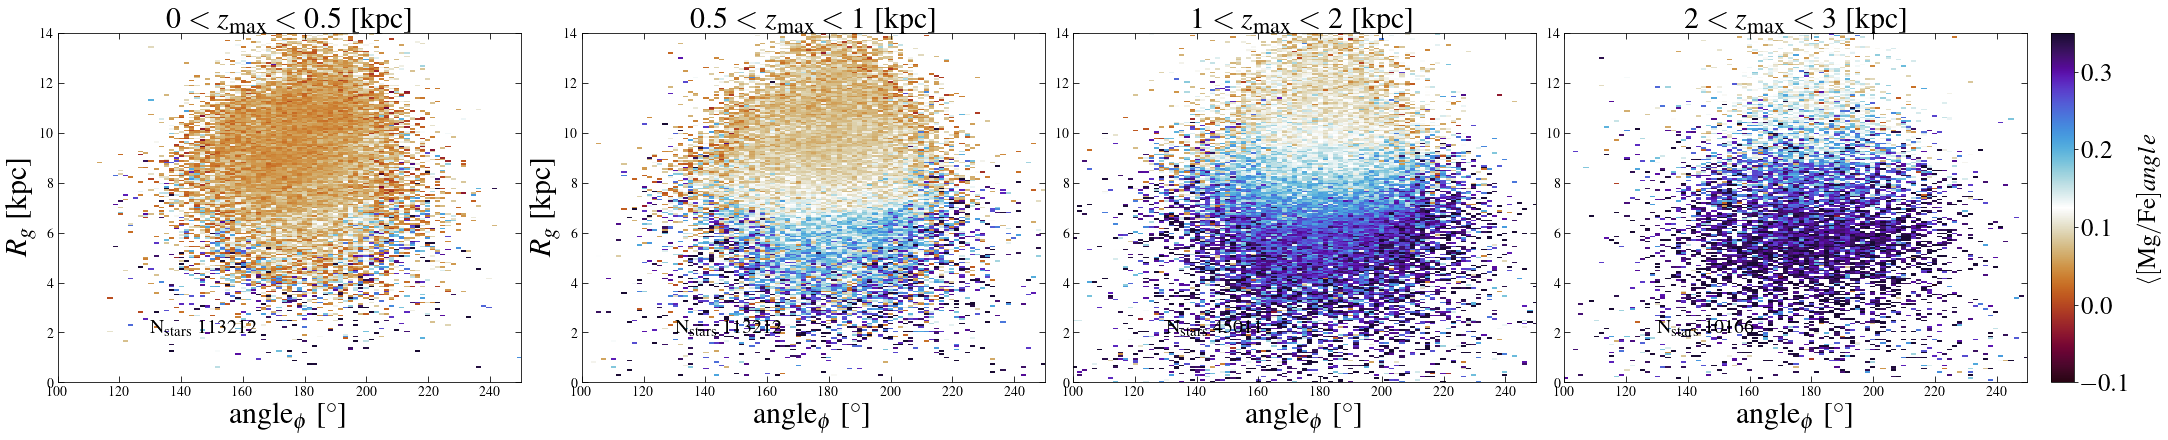

In [320]:
nbins = 218
mask_plot = (Rg>0)&(Rg<14)&(angle_phi>0)&(angle_phi<360)&(np.abs(data['MG_FE'])<1)&(np.abs(data['FE_H'])<4)&mask

fig = plt.figure(figsize=(30,6),constrained_layout=True,facecolor='white')


plt.subplot(1,4,1)
plt.title('$0 < z_{\mathrm{max}} < 0.5$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>0)&(data['z_max']<0.5)],Rg[mask_plot&(data['z_max']>0)&(data['z_max']<0.5)],\
                data['MG_FE'][mask_plot&(data['z_max']>0)&(data['z_max']<0.5)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-0.1,vmax=0.35)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>0)&(data['z_max']<1)])),fontsize=20)

plt.subplot(1,4,2)
plt.title('$0.5 < z_{\mathrm{max}} < 1$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>0.5)&(data['z_max']<1)],Rg[mask_plot&(data['z_max']>0.5)&(data['z_max']<1)],\
                data['MG_FE'][mask_plot&(data['z_max']>0.5)&(data['z_max']<1)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-0.1,vmax=0.35)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>0)&(data['z_max']<1)])),fontsize=20)

plt.subplot(1,4,3)
plt.title('$1 < z_{\mathrm{max}} < 2$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>1)&(data['z_max']<2)],Rg[mask_plot&(data['z_max']>1)&(data['z_max']<2)],\
                data['MG_FE'][mask_plot&(data['z_max']>1)&(data['z_max']<2)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-0.1,vmax=0.35)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
# plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>1)&(data['z_max']<2)])),fontsize=20)

plt.subplot(1,4,4)
plt.title('$2 < z_{\mathrm{max}} < 3$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>2)&(data['z_max']<3)],Rg[mask_plot&(data['z_max']>2)&(data['z_max']<3)],\
                data['MG_FE'][mask_plot&(data['z_max']>2)&(data['z_max']<3)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-0.1,vmax=0.35)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
# plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>2)&(data['z_max']<3)])),fontsize=20)

cbar = fig.colorbar(color, aspect=15)
cbar.set_label(label='$\langle \mathrm{[Mg/Fe]} \rangle$',fontsize=25)
cbar.ax.tick_params(labelsize=25)


(array([5.0000e+01, 9.6000e+01, 2.0000e+02, 4.4100e+02, 8.6800e+02,
        5.3120e+03, 3.5995e+04, 6.8323e+04, 5.1337e+04, 9.3240e+03]),
 array([-2.44059992, -2.14556384, -1.85052788, -1.55549192, -1.26045597,
        -0.96541995, -0.67038393, -0.37534797, -0.08031197,  0.21472403,
         0.50976002]),
 <BarContainer object of 10 artists>)

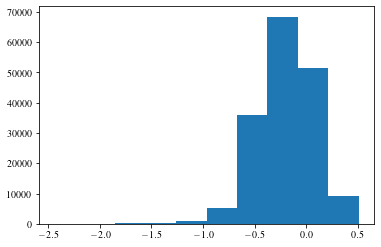

In [321]:
plt.hist(data['FE_H'][mask_plot])

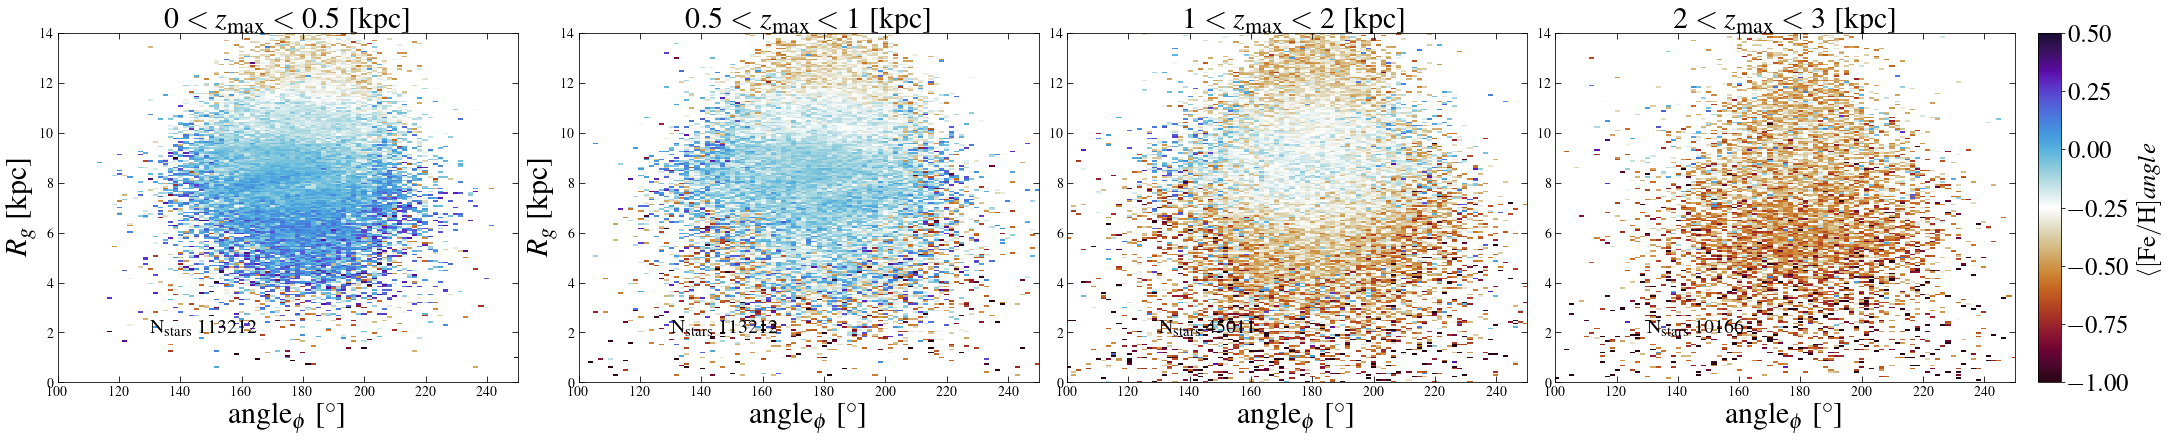

In [322]:
nbins = 218
mask_plot = (Rg>0)&(Rg<14)&(angle_phi>0)&(angle_phi<360)&(np.abs(data['MG_FE'])<1)&(np.abs(data['FE_H'])<4)&mask

fig = plt.figure(figsize=(30,6),constrained_layout=True,facecolor='white')


plt.subplot(1,4,1)
plt.title('$0 < z_{\mathrm{max}} < 0.5$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>0)&(data['z_max']<0.5)],Rg[mask_plot&(data['z_max']>0)&(data['z_max']<0.5)],\
                data['FE_H'][mask_plot&(data['z_max']>0)&(data['z_max']<0.5)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-1,vmax=0.5)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>0)&(data['z_max']<1)])),fontsize=20)

plt.subplot(1,4,2)
plt.title('$0.5 < z_{\mathrm{max}} < 1$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>0.5)&(data['z_max']<1)],Rg[mask_plot&(data['z_max']>0.5)&(data['z_max']<1)],\
                data['FE_H'][mask_plot&(data['z_max']>0.5)&(data['z_max']<1)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-1,vmax=0.5)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>0)&(data['z_max']<1)])),fontsize=20)

plt.subplot(1,4,3)
plt.title('$1 < z_{\mathrm{max}} < 2$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>1)&(data['z_max']<2)],Rg[mask_plot&(data['z_max']>1)&(data['z_max']<2)],\
                data['FE_H'][mask_plot&(data['z_max']>1)&(data['z_max']<2)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-1,vmax=0.5)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
# plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>1)&(data['z_max']<2)])),fontsize=20)

plt.subplot(1,4,4)
plt.title('$2 < z_{\mathrm{max}} < 3$ [kpc]', fontsize=30,pad=6)
binx = np.linspace(0,360,nbins)
biny = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(angle_phi[mask_plot&(data['z_max']>2)&(data['z_max']<3)],Rg[mask_plot&(data['z_max']>2)&(data['z_max']<3)],\
                data['FE_H'][mask_plot&(data['z_max']>2)&(data['z_max']<3)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.fusion,vmin=-1,vmax=0.5)
plt.xlim(100,250)
plt.ylim(0,14)
plt.xlabel('angle$_{\phi}$ [$^{\circ}$]',fontsize=30)
# plt.ylabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
plt.text(130,2,r'N$_{\mathrm{stars}}$ '+str(len(Rg[mask_plot&(data['z_max']>2)&(data['z_max']<3)])),fontsize=20)

cbar = fig.colorbar(color, aspect=15)
cbar.set_label(label='$\langle \mathrm{[Fe/H]} \rangle$',fontsize=25)
cbar.ax.tick_params(labelsize=25)


# $R-z$ and $R_{g}-z_{\mathrm{max}}$

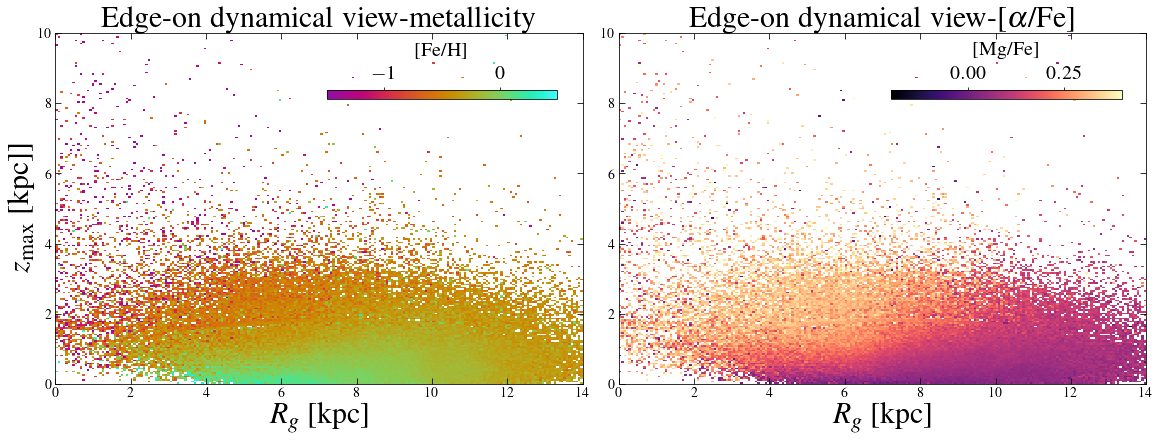

In [348]:
nbins = 218
mask_plot = (Rg>0)&(Rg<14)&(data['z_max']>0)&(data['z_max']<10)&(np.abs(data['MG_FE'])<1)&(np.abs(data['FE_H'])<4)&mask

fig = plt.figure(figsize=(16,6),constrained_layout=True,facecolor='white')

plt.subplot(1,2,1)
plt.title('Edge-on dynamical view-metallicity', fontsize=30,pad=6)
biny = np.linspace(0,10,nbins)
binx = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(Rg[mask_plot],data['z_max'][mask_plot],\
                data['FE_H'][mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.tropical,vmin=-1.5,vmax=0.5)
plt.xlim(0,14)
plt.ylim(0,10)
plt.ylabel('$z_{\mathrm{max}}$ [kpc]]',fontsize=30)
plt.xlabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)

cbar_ax = fig.add_axes([0.28, 0.78, 0.2,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'[Fe/H]',fontsize=20,labelpad=10)
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(1,2,2)
plt.title(r'Edge-on dynamical view-[$\alpha$/Fe]', fontsize=30,pad=6)
biny = np.linspace(0,10,nbins)
binx = np.linspace(0,14,nbins)
hist = stats.binned_statistic_2d(Rg[mask_plot],data['z_max'][mask_plot],\
                data['MG_FE'][mask_plot], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=-0.2,vmax=0.4)
plt.xlim(0,14)
plt.ylim(0,10)
# plt.ylabel('$z_{\mathrm{max}}$ [kpc]]',fontsize=30)
plt.xlabel('$R_{g}$ [kpc]',fontsize=30)
plt.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)

cbar_ax = fig.add_axes([0.77, 0.78, 0.2,0.02])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'[Mg/Fe]',fontsize=20,labelpad=10)
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
